# HAPPY CUSTOMER
### This notebook will be performing a binary classification problem to determine if customers are happy or unhappy. It will determine what is making them happy which will inform the necessary actions to take for the unhappy customers.

In [1]:
# I will be importing all the neccessary libraries I need to work with

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import skew

from sklearn.model_selection import (train_test_split, cross_val_score, GridSearchCV)

import pycaret
from pycaret.classification import (setup, compare_models, tune_model)

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, 
VotingClassifier)
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import (classification_report, accuracy_score, roc_curve, roc_auc_score)

from sklearn.inspection import permutation_importance

In [2]:
# The first thing to do is to load the data into the working enviroment
customers = pd.read_csv("C:/Users/44756/Desktop/Apziva/FirstProject  -  Happycustomer.csv")

In [3]:
# To see what the dataset looks like
customers.head()

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


In [4]:
#To show the number of obeservations and features
customers.shape

(126, 7)

In [5]:
#To check for missing values
customers.isnull().values.any()

False

In [6]:
# To see some information about the dataset and also lookout for an outlier 
# we already know that the values are between 0 and 5, so any number outside of this will be seen as an outlier
customers.describe ()

,Y,X1,X2,X3,X4,X5,X6
count,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000
mean,0.547619,4.333333,2.531746,3.309524,3.746032,3.650794,4.253968
std,0.499714,0.800000,1.114892,1.023440,0.875776,1.147641,0.809311
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,4.000000,2.000000,3.000000,3.000000,3.000000,4.000000
50%,1.000000,5.000000,3.000000,3.000000,4.000000,4.000000,4.000000
75%,1.000000,5.000000,3.000000,4.000000,4.000000,4.000000,5.000000
max,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


From the table above, the minumum number is 0.0000 and the maximum is 5.00000, so we can conclude that there are no outliers

In [7]:
#To check the ratio of happy and unhappy customers
print (customers ['Y']. value_counts())

1    69
0    57
Name: Y, dtype: int64


Data Description : Giving the codebook of the data
- Y = target attribute(Y) with values indicating 0(unhappy) and 1(happy) customers
- X1 = My order was delivered on time
- X2 = contents of my order was as I expected
- X3 = I ordered everything I wanted
- X4 = I paid a good price for my order
- X5 = I am satisfied with my courier
- X6 = The app makes ordering easy for me

In [8]:
# Rename the coloumn in a more meaningful manner
new_cols = ['customer_happiness', 'delivery_time', 'order_quality', 'complete_order', 'price_satisfaction',
             'courier_satisfaction', 'app_satisfaction']

old_cols = list(customers.columns)

customers.rename(columns = dict(zip(old_cols, new_cols)), inplace= True)

In [9]:
# To check the changes
customers.head()

,customer_happiness,delivery_time,order_quality,complete_order,price_satisfaction,courier_satisfaction,app_satisfaction
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


### DATA VISUALIZATION
This will look at the distribution of data using charts. We can then deduce where the company requires to pay more attention
and what field is doing well

In [10]:
#To check if it is normally distributed

n_bins = np.sqrt(len(customers))
n_bins = int(n_bins)

#create a function to plot the histogram for each feature and see if it's normally distributed

def distribution(feature, color, title):
    
    plt.hist(x = feature, bins = n_bins, color = color, data = customers)
    plt.xlabel('Rating')
    plt.ylabel('Frequency')
    plt.title(title)
    return plt.show()

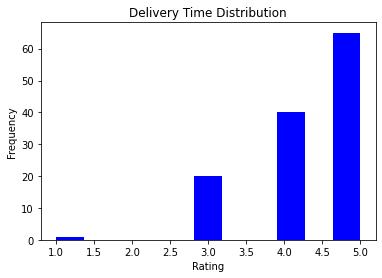

In [11]:
#Delivery Time Distribution

distribution(feature = 'delivery_time', color = 'blue', title = 'Delivery Time Distribution')

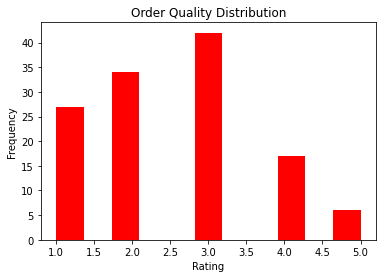

In [12]:
#Order Quality Distribution

distribution(feature = 'order_quality', color = 'red', title = 'Order Quality Distribution')

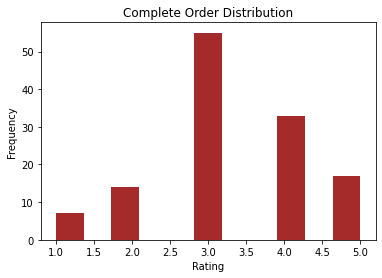

In [13]:
#Complete Order Distribution

distribution(feature = 'complete_order', color = 'brown', title = 'Complete Order Distribution')

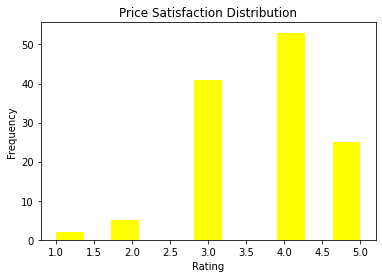

In [14]:
#Price Satisfaction Distribution

distribution(feature = 'price_satisfaction', color = 'yellow', title = 'Price Satisfaction Distribution')

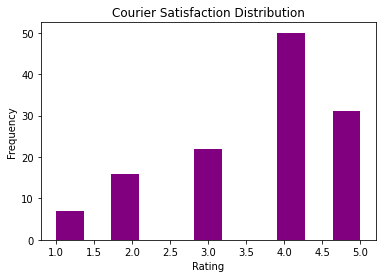

In [15]:
#Courier Satisfaction Distribution

distribution(feature = 'courier_satisfaction', color = 'purple', title = 'Courier Satisfaction Distribution')

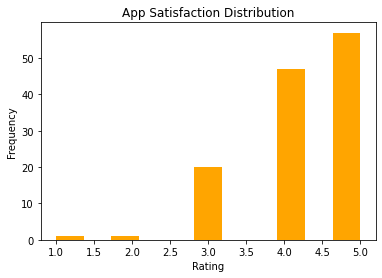

In [16]:
#App Satisfaction Distribution

distribution(feature = 'app_satisfaction', color = 'orange', title = 'App Satisfaction Distribution')

From the histogram above,the data is not normally distributed. 
- Delivery_time, price_satisfaction, courier_satisfaction and app_satisfaction are skewed to the left 
- while order_quality is skewed to the right. 
- Complete_order seems normally distributed.

In [17]:
#  Calculation of skewness using the pandas function

skewValue = customers.skew()

skewValue.sort_values (ascending = False)

order_quality           0.271000
customer_happiness     -0.193659
complete_order         -0.199536
price_satisfaction     -0.422240
courier_satisfaction   -0.699999
app_satisfaction       -0.957590
delivery_time          -1.058468
dtype: float64

From the calculation, it can be concluded that delivery_time is higly skewed. 
- app_satisfaction,courier_satifaction and price_satisfaction are moderately skewed. 
- Order_quality and complete_order are approximately normal distributed.

In [18]:
# Create a new column that says if customer is happy or not 

customers['happiness'] = customers ['customer_happiness'].map ({0: 'unhappy', 1: 'happy'})

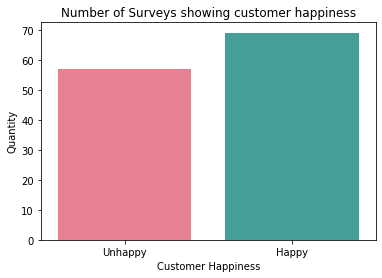

In [19]:
# To create a bar to see if there is a significant difference between happy and unhappy customers

sns.countplot (x = 'customer_happiness', data = customers, 
              palette = 'husl')
plt.xlabel('Customer Happiness')
plt.ylabel('Quantity')
plt.xticks([0, 1], ['Unhappy', 'Happy'])
plt.title("Number of Surveys showing customer happiness")
plt.show()

From the correlation matrix, I am supposed to remove order quality, and price satisfaction, but I want to look further with some visualization techniques.

#### From the value counts, I can see there are some fields the company needs to work on to improve ratings and it may help to gain customers.¶
#### Doing different types of grouping to plot different charts that will tell different insights 

In [20]:
# Grouping by app satisfaction and aggregating the number of happy customers. 

data_app_grouped_happy = customers.groupby('app_satisfaction').agg({'customer_happiness':'sum'})

# Grouping by app satisfaction and aggregating the number of votings. 

data_app_grouped_all = customers.groupby('app_satisfaction').agg({'customer_happiness':'count'})

# Grouping by courier satisfaction and aggregating the number of happy customers. 

data_courier_grouped_happy = customers.groupby('courier_satisfaction').agg({'customer_happiness':'sum'})

# Grouping by courier satisfaction and aggregating the number of votings. 

data_courier_grouped_all = customers.groupby('courier_satisfaction').agg({'customer_happiness':'count'})

#Grouping by price satisfaction and aggregating the number of happy customers.

data_price_grouped_happy = customers.groupby('price_satisfaction').agg({'customer_happiness':'sum'})

# Grouping by price satisfaction and aggregating the number of votings. 

data_price_grouped_all = customers.groupby('price_satisfaction').agg({'customer_happiness':'count'})

# Grouping by order quality

data_order_quality_happy = customers.groupby('order_quality').agg({'customer_happiness':'sum'})

# Grouping by order quality and aggregating the number of votings. 

data_order_grouped_all = customers.groupby('order_quality').agg({'customer_happiness':'count'})

In [21]:
# Grouping by customer happiness and see the average rating in each category

data_grouped = customers.groupby('customer_happiness').agg('mean')
data_grouped

,delivery_time,order_quality,complete_order,price_satisfaction,courier_satisfaction,app_satisfaction
customer_happiness,,,,,,
0,4.087719,2.561404,3.140351,3.684211,3.368421,4.105263
1,4.536232,2.507246,3.449275,3.797101,3.884058,4.376812


From the grouping data frame above, the feature with less rating was the order quality. However, there's not a huge diffe
between the rating from happy and unhappy customers. Nevertheless, it can be concluded that the company needs to work to improve
the order quality since this is behind from all metrics. The company is doing well in delivery time and app satisfaction and
the order completeness is very neutral which is not good and also needs to be improved.

By looking at this, from the modelling, the order quality will not add many value to the model because happy and unhappy customers
still have the order quality as generally bad.

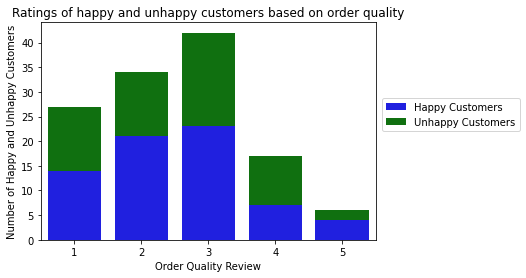

In [22]:
# Save the difference between the votes of all and happy customers to see the number of unhappy votes

diff = data_order_grouped_all - data_order_quality_happy

# See the order quality grouped data frame to see the reviews

sns.barplot(x = data_order_quality_happy.index, y = 'customer_happiness', data = data_order_quality_happy, 
            color = 'blue', label = 'Happy Customers')
sns.barplot(x = diff.index, y = 'customer_happiness', data = diff, bottom = data_order_quality_happy['customer_happiness'],
           color = 'green', label = 'Unhappy Customers')
plt.xlabel('Order Quality Review')
plt.ylabel('Number of Happy and Unhappy Customers')
plt.title('Ratings of happy and unhappy customers based on order quality')
plt.legend(loc = (1.02, 0.5))
plt.show()

The above bar chart sustained what was said earlier, the revies between happy and unhappy customers is very eqaualized which
won't help the model. From the plot, most of the reviews are 3 or less which means this is very bad for the company, and also
because those reviews are from happy customers that still think the order quality is bad.

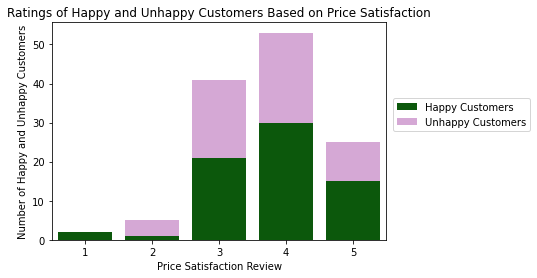

In [23]:
# Save the difference between the votes of all and happy customers to see the number of unhappy votes

diff = data_price_grouped_all - data_price_grouped_happy

# See the order price satisfaction grouped data frame to see the reviews

sns.barplot(x = data_price_grouped_happy.index, y = 'customer_happiness', data = data_price_grouped_happy, 
            color = 'darkgreen',label = 'Happy Customers')
sns.barplot(x = diff.index, y = 'customer_happiness', data = diff, bottom = data_price_grouped_happy['customer_happiness'],
           color = 'plum', label = 'Unhappy Customers')
plt.xlabel('Price Satisfaction Review')
plt.ylabel('Number of Happy and Unhappy Customers')
plt.title('Ratings of Happy and Unhappy Customers Based on Price Satisfaction')
plt.legend(loc = (1.02, 0.5))
plt.show()

From this plot, we might be able to get some insights from the price satisfaction to reach out the desired accuracy

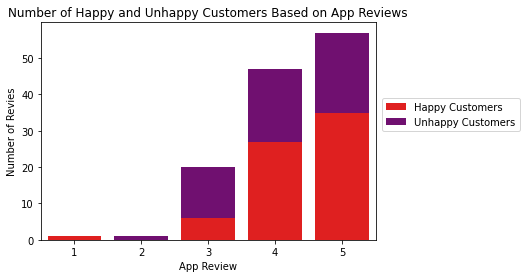

In [24]:
# Calculate the difference between the two grouped data frames to create the bar plot 

diff = data_app_grouped_all - data_app_grouped_happy

#Customer happiness and app reviews

sns.barplot(x = data_app_grouped_happy.index, y = 'customer_happiness', data = data_app_grouped_happy, color = 'red', 
           label = 'Happy Customers')
sns.barplot(x = diff.index, y = 'customer_happiness', data = diff, bottom = data_app_grouped_happy['customer_happiness'],
           color = 'purple', label = 'Unhappy Customers')
plt.xlabel('App Review')
plt.ylabel('Number of Revies')
plt.title('Number of Happy and Unhappy Customers Based on App Reviews')
plt.legend(loc = (1.02, 0.5))
plt.show()

Different than the order quality, most of the customers think the app is good enough. However, still the quantity of votes
is very equalized, though the difference between the mean is higher, so it is interesting to add the app satisfaction to the model

The company seems to do well to make the app easy to order. The ratings are genearally good for happy customers in regards happy customers

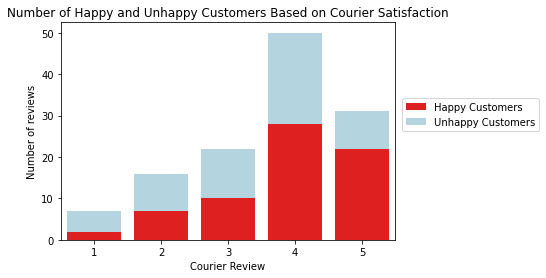

In [25]:
# Calculate the difference of the grouped data frames

diff = data_courier_grouped_all - data_courier_grouped_happy

# Plot the stacked barplot with the courier satisfaction

sns.barplot(x = data_courier_grouped_happy.index, y = 'customer_happiness', data = data_courier_grouped_happy, 
            color = 'red', label = 'Happy Customers')
sns.barplot(x = diff.index, y = 'customer_happiness', data = diff, color = 'lightblue', 
            bottom = data_courier_grouped_happy['customer_happiness'],label = 'Unhappy Customers')
plt.xlabel('Courier Review')
plt.ylabel('Number of reviews')
plt.title('Number of Happy and Unhappy Customers Based on Courier Satisfaction')
plt.legend(loc = (1.02, 0.5))
plt.show()

From the correlation matix, it supports me to remove order quality becuase of the low correlation and keep the app satisfaction
because it at least higher than 0.1, so I can get insights from it on the model

### Correlation Matrix

Plot the correlation matrix to see possible features to remove

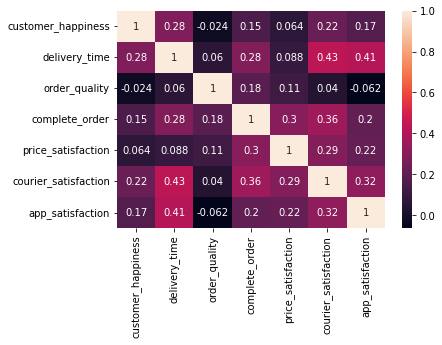

In [26]:
# Create a correlation matrix

corr_matrix = customers.corr()
sns.heatmap(corr_matrix, annot = True)
plt.show()

##  Exploratory Data Analysis

In [27]:

# Bootstrapping to see the statistical significance for the customer happiness variable
# Calculation of the mean and change the type to integer

customer_happiness = customers['customer_happiness'].values.astype('int')
mean = customer_happiness.mean()
print('The current mean for this dataset is {}'.format(mean))

The current mean for this dataset is 0.5476190476190477


In [28]:

# Create a function that returns a list with the list of 1000 different means in case we run the experiment many times
number_attemps = 10000

def bootstrapping_mean(array):
    mean_replicates = []
    bs_replicates = np.empty(number_attemps)
    for i in range(number_attemps):
        bs_replicates = np.random.choice(array, len(array))
        mean_replicates.append(bs_replicates.mean())
    return mean_replicates

In [29]:
# Calculate the confidence interval

mean_replicates = bootstrapping_mean(customer_happiness)
mean_replicates_sorted = sorted(mean_replicates)
lower_bound = np.quantile(mean_replicates_sorted, 0.025)
upper_bound = np.quantile(mean_replicates_sorted, 0.975)
median = np.quantile(mean_replicates_sorted, 0.5)
print('''The 95% confidence interval is between {} and {} that indicates the 95% of confidence intervals where my mean 
reviews is going to be'''.format(lower_bound, upper_bound))

The 95% confidence interval is between 0.4603174603174603 and 0.6349206349206349 that indicates the 95% of confidence intervals where my mean 
reviews is going to be


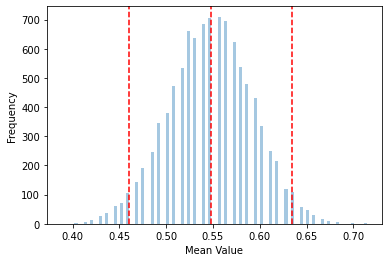

In [30]:
#Visualize a histogram of the mean replicates 
# Try to minimize the bias of the bins distribution

n_bins = np.sqrt(len(mean_replicates))
n_bins = int(n_bins)
sns.distplot(mean_replicates, bins = n_bins, kde = False)
plt.xlabel('Mean Value')
plt.ylabel('Frequency')
plt.axvline(lower_bound, color = 'red', linestyle = '--')
plt.axvline(median, color = 'red', linestyle = '--')
plt.axvline(upper_bound, color = 'red', linestyle = '--')
plt.show()

In [31]:

# See the values below 0.50 (means higher customer unhappiness)

number_unhappy = []

for i in mean_replicates:
    if i < 0.5:
        number_unhappy.append(i)
        
percentage_unhappy = round((len(number_unhappy)/len(mean_replicates))*100,2)      
print('In our bootstrapping, we have a chance of {}% to have more customers unhappy'.format(percentage_unhappy))

In our bootstrapping, we have a chance of 12.49% to have more customers unhappy


## Feature Engineering

In [32]:
# Transform the variables I got that were skewed into normal distributions by applying boxcops transformation

# transform training data & save lambda value 

fitted_data1, fitted_lambda1 = stats.boxcox(customers['delivery_time'])

fitted_data2, fitted_lambda2 = stats.boxcox(customers['app_satisfaction'])

fitted_data3, fitted_lambda3 = stats.boxcox(customers['courier_satisfaction'])

fitted_data4, fitted_lambda4 = stats.boxcox(customers['price_satisfaction'])

In [33]:
# Change the existing columns to the new fitted data to have normal distribution and improve the results

customers['deliverey_time'] = fitted_data1

customers['app_satisfaction'] = fitted_data2

customers['courier_satisfaction'] = fitted_data3

customers['price_satisfaction'] = fitted_data4

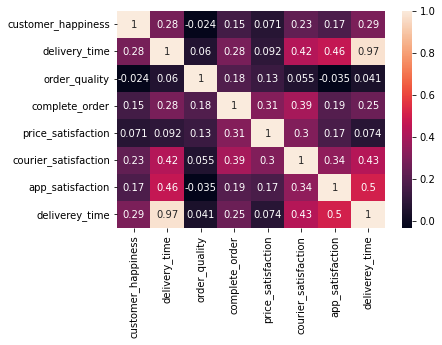

In [34]:

# Plot again the correlation matrix to see if I could still remove order_quality variable

corr_matrix = customers.corr()
sns.heatmap(corr_matrix, annot = True)
plt.show()

In [35]:
# Delete order_quality and price_satisfaction

customers2 = customers[['customer_happiness', 'courier_satisfaction', 'complete_order', 'delivery_time','app_satisfaction',
             ]]

customers2 = pd.get_dummies(customers2, columns = ['delivery_time','complete_order', 'courier_satisfaction', 'app_satisfaction'
                                       ], drop_first = False)

In [37]:
# Delete order_quality

customers3 = customers[['customer_happiness', 'courier_satisfaction', 'complete_order', 'delivery_time','app_satisfaction',
             'price_satisfaction']]

customers3 = pd.get_dummies(customers3, columns = ['delivery_time','complete_order', 'courier_satisfaction', 'app_satisfaction',
                                       'price_satisfaction'], drop_first = False)

In [38]:
# Using the complete dataset

customers4 = pd.get_dummies(customers, columns = ['delivery_time','complete_order', 'courier_satisfaction', 'app_satisfaction',
                                       'price_satisfaction', 'order_quality'], drop_first = False)

customers4.drop('happiness', axis = 1, inplace = True)

In [39]:
# We are dividing the data into the train and the test data set. 
# Since the dataset is very small, we may have problems with overfitting the data
# We will evaluate the model in terms on how it behaves with the test data set

# Creation of the X (independent variables) and the y arrays (dependant variables)

X = customers2.drop(columns = 'customer_happiness', axis = 1).values
y = customers2['customer_happiness'].values
# Division of the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [40]:
# Creation of the X2 (independent variables) and the y2 arrays (dependant variables) for the second data set

X2 = customers3.drop(columns = 'customer_happiness', axis = 1).values
y2 = customers3['customer_happiness'].values
# Division of the data

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = 0.25, random_state = 42)

In [41]:
# Creation of the X3 (independent variables) and the y3 arrays (dependant variables) for the third data set

X3 = customers4.drop(columns = 'customer_happiness', axis = 1).values
y3 = customers4['customer_happiness'].values
# Division of the data

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size = 0.25, random_state = 42)

In [42]:
# Function that converts the arrays created to data frame

def converter_df(train_independent, train_dependent):
    df = pd.DataFrame(train_independent)
    df['dependant'] = train_dependent
    return df

In [43]:
# Convert the three arrays of train data set into data frames

df1 = converter_df(train_independent = X_train, train_dependent = y_train)
df2 = converter_df(train_independent = X_train2, train_dependent = y_train2)
df3 = converter_df(train_independent = X_train3, train_dependent = y_train3)

## Modelling

I will use PyCaret first to check what classifiers better perform on the dataset

In [44]:
# setup the dataset

grid = setup (data = df1, target = df1.columns[-1], html = False, silent = True, verbose = False)

# evaluate models and compare models

best = compare_models()

# report the best model

print(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.5786,0.5424,0.7,0.6283,0.6517,0.0939,0.1175,0.573


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6357,0.5472,0.9,0.6321,0.7366,0.1579,0.1895,0.057
lr,Logistic Regression,0.5786,0.5424,0.7,0.6283,0.6517,0.0939,0.1175,0.573


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6357,0.5472,0.9000,0.6321,0.7366,0.1579,0.1895,0.057
lr,Logistic Regression,0.5786,0.5424,0.7000,0.6283,0.6517,0.0939,0.1175,0.573
nb,Naive Bayes,0.4143,0.5424,0.1333,0.1933,0.1400,-0.0693,-0.0767,0.006


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6357,0.5472,0.9000,0.6321,0.7366,0.1579,0.1895,0.057
lr,Logistic Regression,0.5786,0.5424,0.7000,0.6283,0.6517,0.0939,0.1175,0.573
dt,Decision Tree Classifier,0.5595,0.5778,0.5417,0.6333,0.5733,0.0970,0.0929,0.005
nb,Naive Bayes,0.4143,0.5424,0.1333,0.1933,0.1400,-0.0693,-0.0767,0.006


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6357,0.5472,0.9000,0.6321,0.7366,0.1579,0.1895,0.057
lr,Logistic Regression,0.5786,0.5424,0.7000,0.6283,0.6517,0.0939,0.1175,0.573
dt,Decision Tree Classifier,0.5595,0.5778,0.5417,0.6333,0.5733,0.0970,0.0929,0.005
svm,SVM - Linear Kernel,0.5548,0.0000,0.7083,0.6505,0.6303,0.0593,0.0859,0.008
nb,Naive Bayes,0.4143,0.5424,0.1333,0.1933,0.1400,-0.0693,-0.0767,0.006


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6357,0.5472,0.9000,0.6321,0.7366,0.1579,0.1895,0.057
lr,Logistic Regression,0.5786,0.5424,0.7000,0.6283,0.6517,0.0939,0.1175,0.573
ridge,Ridge Classifier,0.5643,0.0000,0.6750,0.6183,0.6350,0.0685,0.0917,0.005
dt,Decision Tree Classifier,0.5595,0.5778,0.5417,0.6333,0.5733,0.0970,0.0929,0.005
svm,SVM - Linear Kernel,0.5548,0.0000,0.7083,0.6505,0.6303,0.0593,0.0859,0.008
nb,Naive Bayes,0.4143,0.5424,0.1333,0.1933,0.1400,-0.0693,-0.0767,0.006


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6357,0.5472,0.9000,0.6321,0.7366,0.1579,0.1895,0.057
rf,Random Forest Classifier,0.6190,0.5799,0.7000,0.6671,0.6608,0.1563,0.1624,0.191
lr,Logistic Regression,0.5786,0.5424,0.7000,0.6283,0.6517,0.0939,0.1175,0.573
ridge,Ridge Classifier,0.5643,0.0000,0.6750,0.6183,0.6350,0.0685,0.0917,0.005
dt,Decision Tree Classifier,0.5595,0.5778,0.5417,0.6333,0.5733,0.0970,0.0929,0.005
svm,SVM - Linear Kernel,0.5548,0.0000,0.7083,0.6505,0.6303,0.0593,0.0859,0.008
nb,Naive Bayes,0.4143,0.5424,0.1333,0.1933,0.1400,-0.0693,-0.0767,0.006


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6357,0.5472,0.9000,0.6321,0.7366,0.1579,0.1895,0.057
rf,Random Forest Classifier,0.6190,0.5799,0.7000,0.6671,0.6608,0.1563,0.1624,0.191
lr,Logistic Regression,0.5786,0.5424,0.7000,0.6283,0.6517,0.0939,0.1175,0.573
ridge,Ridge Classifier,0.5643,0.0000,0.6750,0.6183,0.6350,0.0685,0.0917,0.005
dt,Decision Tree Classifier,0.5595,0.5778,0.5417,0.6333,0.5733,0.0970,0.0929,0.005
svm,SVM - Linear Kernel,0.5548,0.0000,0.7083,0.6505,0.6303,0.0593,0.0859,0.008
nb,Naive Bayes,0.4143,0.5424,0.1333,0.1933,0.1400,-0.0693,-0.0767,0.006
qda,Quadratic Discriminant Analysis,0.4143,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.009


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6357,0.5472,0.9000,0.6321,0.7366,0.1579,0.1895,0.057
rf,Random Forest Classifier,0.6190,0.5799,0.7000,0.6671,0.6608,0.1563,0.1624,0.191
lr,Logistic Regression,0.5786,0.5424,0.7000,0.6283,0.6517,0.0939,0.1175,0.573
ridge,Ridge Classifier,0.5643,0.0000,0.6750,0.6183,0.6350,0.0685,0.0917,0.005
dt,Decision Tree Classifier,0.5595,0.5778,0.5417,0.6333,0.5733,0.0970,0.0929,0.005
svm,SVM - Linear Kernel,0.5548,0.0000,0.7083,0.6505,0.6303,0.0593,0.0859,0.008
ada,Ada Boost Classifier,0.5476,0.4924,0.6750,0.6017,0.6279,0.0398,0.0658,0.027
nb,Naive Bayes,0.4143,0.5424,0.1333,0.1933,0.1400,-0.0693,-0.0767,0.006
qda,Quadratic Discriminant Analysis,0.4143,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.009


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6357,0.5472,0.9000,0.6321,0.7366,0.1579,0.1895,0.057
gbc,Gradient Boosting Classifier,0.6214,0.5688,0.7083,0.6717,0.6801,0.1833,0.1834,0.018
rf,Random Forest Classifier,0.6190,0.5799,0.7000,0.6671,0.6608,0.1563,0.1624,0.191
lr,Logistic Regression,0.5786,0.5424,0.7000,0.6283,0.6517,0.0939,0.1175,0.573
ridge,Ridge Classifier,0.5643,0.0000,0.6750,0.6183,0.6350,0.0685,0.0917,0.005
dt,Decision Tree Classifier,0.5595,0.5778,0.5417,0.6333,0.5733,0.0970,0.0929,0.005
svm,SVM - Linear Kernel,0.5548,0.0000,0.7083,0.6505,0.6303,0.0593,0.0859,0.008
ada,Ada Boost Classifier,0.5476,0.4924,0.6750,0.6017,0.6279,0.0398,0.0658,0.027
nb,Naive Bayes,0.4143,0.5424,0.1333,0.1933,0.1400,-0.0693,-0.0767,0.006
qda,Quadratic Discriminant Analysis,0.4143,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.009


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6357,0.5472,0.9000,0.6321,0.7366,0.1579,0.1895,0.057
gbc,Gradient Boosting Classifier,0.6214,0.5688,0.7083,0.6717,0.6801,0.1833,0.1834,0.018
rf,Random Forest Classifier,0.6190,0.5799,0.7000,0.6671,0.6608,0.1563,0.1624,0.191
lr,Logistic Regression,0.5786,0.5424,0.7000,0.6283,0.6517,0.0939,0.1175,0.573
ridge,Ridge Classifier,0.5643,0.0000,0.6750,0.6183,0.6350,0.0685,0.0917,0.005
dt,Decision Tree Classifier,0.5595,0.5778,0.5417,0.6333,0.5733,0.0970,0.0929,0.005
svm,SVM - Linear Kernel,0.5548,0.0000,0.7083,0.6505,0.6303,0.0593,0.0859,0.008
lda,Linear Discriminant Analysis,0.5500,0.5340,0.6500,0.6017,0.6112,0.0448,0.0659,0.007
ada,Ada Boost Classifier,0.5476,0.4924,0.6750,0.6017,0.6279,0.0398,0.0658,0.027
nb,Naive Bayes,0.4143,0.5424,0.1333,0.1933,0.1400,-0.0693,-0.0767,0.006


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6357,0.5472,0.9000,0.6321,0.7366,0.1579,0.1895,0.057
gbc,Gradient Boosting Classifier,0.6214,0.5688,0.7083,0.6717,0.6801,0.1833,0.1834,0.018
rf,Random Forest Classifier,0.6190,0.5799,0.7000,0.6671,0.6608,0.1563,0.1624,0.191
et,Extra Trees Classifier,0.6071,0.5819,0.6500,0.6633,0.6403,0.1608,0.1645,0.181
lr,Logistic Regression,0.5786,0.5424,0.7000,0.6283,0.6517,0.0939,0.1175,0.573
ridge,Ridge Classifier,0.5643,0.0000,0.6750,0.6183,0.6350,0.0685,0.0917,0.005
dt,Decision Tree Classifier,0.5595,0.5778,0.5417,0.6333,0.5733,0.0970,0.0929,0.005
svm,SVM - Linear Kernel,0.5548,0.0000,0.7083,0.6505,0.6303,0.0593,0.0859,0.008
lda,Linear Discriminant Analysis,0.5500,0.5340,0.6500,0.6017,0.6112,0.0448,0.0659,0.007
ada,Ada Boost Classifier,0.5476,0.4924,0.6750,0.6017,0.6279,0.0398,0.0658,0.027


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6357,0.5472,0.9000,0.6321,0.7366,0.1579,0.1895,0.057
gbc,Gradient Boosting Classifier,0.6214,0.5688,0.7083,0.6717,0.6801,0.1833,0.1834,0.018
rf,Random Forest Classifier,0.6190,0.5799,0.7000,0.6671,0.6608,0.1563,0.1624,0.191
et,Extra Trees Classifier,0.6071,0.5819,0.6500,0.6633,0.6403,0.1608,0.1645,0.181
lr,Logistic Regression,0.5786,0.5424,0.7000,0.6283,0.6517,0.0939,0.1175,0.573
ridge,Ridge Classifier,0.5643,0.0000,0.6750,0.6183,0.6350,0.0685,0.0917,0.005
dt,Decision Tree Classifier,0.5595,0.5778,0.5417,0.6333,0.5733,0.0970,0.0929,0.005
svm,SVM - Linear Kernel,0.5548,0.0000,0.7083,0.6505,0.6303,0.0593,0.0859,0.008
lightgbm,Light Gradient Boosting Machine,0.5548,0.6514,0.7167,0.6171,0.6460,0.0376,0.0595,0.082
lda,Linear Discriminant Analysis,0.5500,0.5340,0.6500,0.6017,0.6112,0.0448,0.0659,0.007


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6357,0.5472,0.9000,0.6321,0.7366,0.1579,0.1895,0.057
gbc,Gradient Boosting Classifier,0.6214,0.5688,0.7083,0.6717,0.6801,0.1833,0.1834,0.018
rf,Random Forest Classifier,0.6190,0.5799,0.7000,0.6671,0.6608,0.1563,0.1624,0.191
et,Extra Trees Classifier,0.6071,0.5819,0.6500,0.6633,0.6403,0.1608,0.1645,0.181
lr,Logistic Regression,0.5786,0.5424,0.7000,0.6283,0.6517,0.0939,0.1175,0.573
ridge,Ridge Classifier,0.5643,0.0000,0.6750,0.6183,0.6350,0.0685,0.0917,0.005
dt,Decision Tree Classifier,0.5595,0.5778,0.5417,0.6333,0.5733,0.0970,0.0929,0.005
svm,SVM - Linear Kernel,0.5548,0.0000,0.7083,0.6505,0.6303,0.0593,0.0859,0.008
lightgbm,Light Gradient Boosting Machine,0.5548,0.6514,0.7167,0.6171,0.6460,0.0376,0.0595,0.082
lda,Linear Discriminant Analysis,0.5500,0.5340,0.6500,0.6017,0.6112,0.0448,0.0659,0.007


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')


In [45]:
# setup the dataset

grid = setup(data = df2, target = df1.columns[-1], html = False, silent = True, verbose = False)

# evaluate models and compare models

best = compare_models()

# report the best model

print(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6476,0.7472,0.7333,0.7217,0.7026,0.2806,0.2945,0.027


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6476,0.7472,0.7333,0.7217,0.7026,0.2806,0.2945,0.027
knn,K Neighbors Classifier,0.5714,0.6069,0.7583,0.6071,0.6570,0.0941,0.1032,0.510


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6476,0.7472,0.7333,0.7217,0.7026,0.2806,0.2945,0.027
nb,Naive Bayes,0.6071,0.7028,0.9167,0.6105,0.7216,0.1559,0.1588,0.005
knn,K Neighbors Classifier,0.5714,0.6069,0.7583,0.6071,0.6570,0.0941,0.1032,0.510


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6476,0.7472,0.7333,0.7217,0.7026,0.2806,0.2945,0.027
dt,Decision Tree Classifier,0.6333,0.6250,0.6917,0.6483,0.6582,0.2522,0.2687,0.008
nb,Naive Bayes,0.6071,0.7028,0.9167,0.6105,0.7216,0.1559,0.1588,0.005
knn,K Neighbors Classifier,0.5714,0.6069,0.7583,0.6071,0.6570,0.0941,0.1032,0.510


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6476,0.7472,0.7333,0.7217,0.7026,0.2806,0.2945,0.027
dt,Decision Tree Classifier,0.6333,0.6250,0.6917,0.6483,0.6582,0.2522,0.2687,0.008
svm,SVM - Linear Kernel,0.6310,0.0000,0.7500,0.6417,0.6772,0.2209,0.2238,0.006
nb,Naive Bayes,0.6071,0.7028,0.9167,0.6105,0.7216,0.1559,0.1588,0.005
knn,K Neighbors Classifier,0.5714,0.6069,0.7583,0.6071,0.6570,0.0941,0.1032,0.510


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6476,0.7472,0.7333,0.7217,0.7026,0.2806,0.2945,0.027
ridge,Ridge Classifier,0.6476,0.0000,0.7333,0.7217,0.7026,0.2806,0.2945,0.005
dt,Decision Tree Classifier,0.6333,0.6250,0.6917,0.6483,0.6582,0.2522,0.2687,0.008
svm,SVM - Linear Kernel,0.6310,0.0000,0.7500,0.6417,0.6772,0.2209,0.2238,0.006
nb,Naive Bayes,0.6071,0.7028,0.9167,0.6105,0.7216,0.1559,0.1588,0.005
knn,K Neighbors Classifier,0.5714,0.6069,0.7583,0.6071,0.6570,0.0941,0.1032,0.510


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.6762,0.7472,0.7417,0.7033,0.7054,0.3339,0.3640,0.185
lr,Logistic Regression,0.6476,0.7472,0.7333,0.7217,0.7026,0.2806,0.2945,0.027
ridge,Ridge Classifier,0.6476,0.0000,0.7333,0.7217,0.7026,0.2806,0.2945,0.005
dt,Decision Tree Classifier,0.6333,0.6250,0.6917,0.6483,0.6582,0.2522,0.2687,0.008
svm,SVM - Linear Kernel,0.6310,0.0000,0.7500,0.6417,0.6772,0.2209,0.2238,0.006
nb,Naive Bayes,0.6071,0.7028,0.9167,0.6105,0.7216,0.1559,0.1588,0.005
knn,K Neighbors Classifier,0.5714,0.6069,0.7583,0.6071,0.6570,0.0941,0.1032,0.510


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.6762,0.7472,0.7417,0.7033,0.7054,0.3339,0.3640,0.185
lr,Logistic Regression,0.6476,0.7472,0.7333,0.7217,0.7026,0.2806,0.2945,0.027
ridge,Ridge Classifier,0.6476,0.0000,0.7333,0.7217,0.7026,0.2806,0.2945,0.005
dt,Decision Tree Classifier,0.6333,0.6250,0.6917,0.6483,0.6582,0.2522,0.2687,0.008
svm,SVM - Linear Kernel,0.6310,0.0000,0.7500,0.6417,0.6772,0.2209,0.2238,0.006
nb,Naive Bayes,0.6071,0.7028,0.9167,0.6105,0.7216,0.1559,0.1588,0.005
knn,K Neighbors Classifier,0.5714,0.6069,0.7583,0.6071,0.6570,0.0941,0.1032,0.510
qda,Quadratic Discriminant Analysis,0.5381,0.0000,0.9000,0.4952,0.6376,0.0000,0.0000,0.008


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.6762,0.7472,0.7417,0.7033,0.7054,0.3339,0.3640,0.185
ada,Ada Boost Classifier,0.6738,0.7056,0.7250,0.7383,0.7120,0.3439,0.3561,0.026
lr,Logistic Regression,0.6476,0.7472,0.7333,0.7217,0.7026,0.2806,0.2945,0.027
ridge,Ridge Classifier,0.6476,0.0000,0.7333,0.7217,0.7026,0.2806,0.2945,0.005
dt,Decision Tree Classifier,0.6333,0.6250,0.6917,0.6483,0.6582,0.2522,0.2687,0.008
svm,SVM - Linear Kernel,0.6310,0.0000,0.7500,0.6417,0.6772,0.2209,0.2238,0.006
nb,Naive Bayes,0.6071,0.7028,0.9167,0.6105,0.7216,0.1559,0.1588,0.005
knn,K Neighbors Classifier,0.5714,0.6069,0.7583,0.6071,0.6570,0.0941,0.1032,0.510
qda,Quadratic Discriminant Analysis,0.5381,0.0000,0.9000,0.4952,0.6376,0.0000,0.0000,0.008


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7071,0.8264,0.7417,0.7700,0.7206,0.3993,0.4403,0.017
rf,Random Forest Classifier,0.6762,0.7472,0.7417,0.7033,0.7054,0.3339,0.3640,0.185
ada,Ada Boost Classifier,0.6738,0.7056,0.7250,0.7383,0.7120,0.3439,0.3561,0.026
lr,Logistic Regression,0.6476,0.7472,0.7333,0.7217,0.7026,0.2806,0.2945,0.027
ridge,Ridge Classifier,0.6476,0.0000,0.7333,0.7217,0.7026,0.2806,0.2945,0.005
dt,Decision Tree Classifier,0.6333,0.6250,0.6917,0.6483,0.6582,0.2522,0.2687,0.008
svm,SVM - Linear Kernel,0.6310,0.0000,0.7500,0.6417,0.6772,0.2209,0.2238,0.006
nb,Naive Bayes,0.6071,0.7028,0.9167,0.6105,0.7216,0.1559,0.1588,0.005
knn,K Neighbors Classifier,0.5714,0.6069,0.7583,0.6071,0.6570,0.0941,0.1032,0.510
qda,Quadratic Discriminant Analysis,0.5381,0.0000,0.9000,0.4952,0.6376,0.0000,0.0000,0.008


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7071,0.8264,0.7417,0.7700,0.7206,0.3993,0.4403,0.017
rf,Random Forest Classifier,0.6762,0.7472,0.7417,0.7033,0.7054,0.3339,0.3640,0.185
ada,Ada Boost Classifier,0.6738,0.7056,0.7250,0.7383,0.7120,0.3439,0.3561,0.026
lda,Linear Discriminant Analysis,0.6643,0.6694,0.7333,0.7383,0.6976,0.3176,0.3579,0.006
lr,Logistic Regression,0.6476,0.7472,0.7333,0.7217,0.7026,0.2806,0.2945,0.027
ridge,Ridge Classifier,0.6476,0.0000,0.7333,0.7217,0.7026,0.2806,0.2945,0.005
dt,Decision Tree Classifier,0.6333,0.6250,0.6917,0.6483,0.6582,0.2522,0.2687,0.008
svm,SVM - Linear Kernel,0.6310,0.0000,0.7500,0.6417,0.6772,0.2209,0.2238,0.006
nb,Naive Bayes,0.6071,0.7028,0.9167,0.6105,0.7216,0.1559,0.1588,0.005
knn,K Neighbors Classifier,0.5714,0.6069,0.7583,0.6071,0.6570,0.0941,0.1032,0.510


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7071,0.8264,0.7417,0.7700,0.7206,0.3993,0.4403,0.017
et,Extra Trees Classifier,0.7071,0.6639,0.7500,0.7600,0.7156,0.4064,0.4526,0.197
rf,Random Forest Classifier,0.6762,0.7472,0.7417,0.7033,0.7054,0.3339,0.3640,0.185
ada,Ada Boost Classifier,0.6738,0.7056,0.7250,0.7383,0.7120,0.3439,0.3561,0.026
lda,Linear Discriminant Analysis,0.6643,0.6694,0.7333,0.7383,0.6976,0.3176,0.3579,0.006
lr,Logistic Regression,0.6476,0.7472,0.7333,0.7217,0.7026,0.2806,0.2945,0.027
ridge,Ridge Classifier,0.6476,0.0000,0.7333,0.7217,0.7026,0.2806,0.2945,0.005
dt,Decision Tree Classifier,0.6333,0.6250,0.6917,0.6483,0.6582,0.2522,0.2687,0.008
svm,SVM - Linear Kernel,0.6310,0.0000,0.7500,0.6417,0.6772,0.2209,0.2238,0.006
nb,Naive Bayes,0.6071,0.7028,0.9167,0.6105,0.7216,0.1559,0.1588,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7262,0.8132,0.7583,0.7933,0.7576,0.4412,0.4651,0.079
gbc,Gradient Boosting Classifier,0.7071,0.8264,0.7417,0.7700,0.7206,0.3993,0.4403,0.017
et,Extra Trees Classifier,0.7071,0.6639,0.7500,0.7600,0.7156,0.4064,0.4526,0.197
rf,Random Forest Classifier,0.6762,0.7472,0.7417,0.7033,0.7054,0.3339,0.3640,0.185
ada,Ada Boost Classifier,0.6738,0.7056,0.7250,0.7383,0.7120,0.3439,0.3561,0.026
lda,Linear Discriminant Analysis,0.6643,0.6694,0.7333,0.7383,0.6976,0.3176,0.3579,0.006
lr,Logistic Regression,0.6476,0.7472,0.7333,0.7217,0.7026,0.2806,0.2945,0.027
ridge,Ridge Classifier,0.6476,0.0000,0.7333,0.7217,0.7026,0.2806,0.2945,0.005
dt,Decision Tree Classifier,0.6333,0.6250,0.6917,0.6483,0.6582,0.2522,0.2687,0.008
svm,SVM - Linear Kernel,0.6310,0.0000,0.7500,0.6417,0.6772,0.2209,0.2238,0.006


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7262,0.8132,0.7583,0.7933,0.7576,0.4412,0.4651,0.079
gbc,Gradient Boosting Classifier,0.7071,0.8264,0.7417,0.7700,0.7206,0.3993,0.4403,0.017
et,Extra Trees Classifier,0.7071,0.6639,0.7500,0.7600,0.7156,0.4064,0.4526,0.197
rf,Random Forest Classifier,0.6762,0.7472,0.7417,0.7033,0.7054,0.3339,0.3640,0.185
ada,Ada Boost Classifier,0.6738,0.7056,0.7250,0.7383,0.7120,0.3439,0.3561,0.026
lda,Linear Discriminant Analysis,0.6643,0.6694,0.7333,0.7383,0.6976,0.3176,0.3579,0.006
lr,Logistic Regression,0.6476,0.7472,0.7333,0.7217,0.7026,0.2806,0.2945,0.027
ridge,Ridge Classifier,0.6476,0.0000,0.7333,0.7217,0.7026,0.2806,0.2945,0.005
dt,Decision Tree Classifier,0.6333,0.6250,0.6917,0.6483,0.6582,0.2522,0.2687,0.008
svm,SVM - Linear Kernel,0.6310,0.0000,0.7500,0.6417,0.6772,0.2209,0.2238,0.006


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=7880, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [46]:

# setup the dataset

grid = setup(data = df3, target = df1.columns[-1], html = False, silent = True, verbose = False)

# evaluate models and compare models

best = compare_models()

# report the best model

print(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.5548,0.5444,0.6917,0.6133,0.631,0.0844,0.0981,0.013


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6643,0.5847,0.8417,0.6717,0.7355,0.2958,0.3325,0.052
lr,Logistic Regression,0.5548,0.5444,0.6917,0.6133,0.6310,0.0844,0.0981,0.013


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6643,0.5847,0.8417,0.6717,0.7355,0.2958,0.3325,0.052
lr,Logistic Regression,0.5548,0.5444,0.6917,0.6133,0.6310,0.0844,0.0981,0.013
nb,Naive Bayes,0.4452,0.5500,0.2750,0.4067,0.3116,-0.0336,-0.0567,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6643,0.5847,0.8417,0.6717,0.7355,0.2958,0.3325,0.052
dt,Decision Tree Classifier,0.5833,0.5792,0.6250,0.6133,0.5941,0.1256,0.1590,0.005
lr,Logistic Regression,0.5548,0.5444,0.6917,0.6133,0.6310,0.0844,0.0981,0.013
nb,Naive Bayes,0.4452,0.5500,0.2750,0.4067,0.3116,-0.0336,-0.0567,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6643,0.5847,0.8417,0.6717,0.7355,0.2958,0.3325,0.052
svm,SVM - Linear Kernel,0.6048,0.0000,0.7250,0.5210,0.5893,0.2193,0.2399,0.006
dt,Decision Tree Classifier,0.5833,0.5792,0.6250,0.6133,0.5941,0.1256,0.1590,0.005
lr,Logistic Regression,0.5548,0.5444,0.6917,0.6133,0.6310,0.0844,0.0981,0.013
nb,Naive Bayes,0.4452,0.5500,0.2750,0.4067,0.3116,-0.0336,-0.0567,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6643,0.5847,0.8417,0.6717,0.7355,0.2958,0.3325,0.052
svm,SVM - Linear Kernel,0.6048,0.0000,0.7250,0.5210,0.5893,0.2193,0.2399,0.006
dt,Decision Tree Classifier,0.5833,0.5792,0.6250,0.6133,0.5941,0.1256,0.1590,0.005
lr,Logistic Regression,0.5548,0.5444,0.6917,0.6133,0.6310,0.0844,0.0981,0.013
ridge,Ridge Classifier,0.4500,0.0000,0.5583,0.5083,0.5148,-0.1068,-0.1273,0.005
nb,Naive Bayes,0.4452,0.5500,0.2750,0.4067,0.3116,-0.0336,-0.0567,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6643,0.5847,0.8417,0.6717,0.7355,0.2958,0.3325,0.052
svm,SVM - Linear Kernel,0.6048,0.0000,0.7250,0.5210,0.5893,0.2193,0.2399,0.006
rf,Random Forest Classifier,0.5976,0.5576,0.7500,0.6333,0.6784,0.1447,0.1495,0.200
dt,Decision Tree Classifier,0.5833,0.5792,0.6250,0.6133,0.5941,0.1256,0.1590,0.005
lr,Logistic Regression,0.5548,0.5444,0.6917,0.6133,0.6310,0.0844,0.0981,0.013
ridge,Ridge Classifier,0.4500,0.0000,0.5583,0.5083,0.5148,-0.1068,-0.1273,0.005
nb,Naive Bayes,0.4452,0.5500,0.2750,0.4067,0.3116,-0.0336,-0.0567,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6643,0.5847,0.8417,0.6717,0.7355,0.2958,0.3325,0.052
svm,SVM - Linear Kernel,0.6048,0.0000,0.7250,0.5210,0.5893,0.2193,0.2399,0.006
rf,Random Forest Classifier,0.5976,0.5576,0.7500,0.6333,0.6784,0.1447,0.1495,0.200
dt,Decision Tree Classifier,0.5833,0.5792,0.6250,0.6133,0.5941,0.1256,0.1590,0.005
lr,Logistic Regression,0.5548,0.5444,0.6917,0.6133,0.6310,0.0844,0.0981,0.013
qda,Quadratic Discriminant Analysis,0.5524,0.5458,0.8250,0.5481,0.6332,0.0824,0.1065,0.005
ridge,Ridge Classifier,0.4500,0.0000,0.5583,0.5083,0.5148,-0.1068,-0.1273,0.005
nb,Naive Bayes,0.4452,0.5500,0.2750,0.4067,0.3116,-0.0336,-0.0567,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6643,0.5847,0.8417,0.6717,0.7355,0.2958,0.3325,0.052
svm,SVM - Linear Kernel,0.6048,0.0000,0.7250,0.5210,0.5893,0.2193,0.2399,0.006
rf,Random Forest Classifier,0.5976,0.5576,0.7500,0.6333,0.6784,0.1447,0.1495,0.200
dt,Decision Tree Classifier,0.5833,0.5792,0.6250,0.6133,0.5941,0.1256,0.1590,0.005
lr,Logistic Regression,0.5548,0.5444,0.6917,0.6133,0.6310,0.0844,0.0981,0.013
qda,Quadratic Discriminant Analysis,0.5524,0.5458,0.8250,0.5481,0.6332,0.0824,0.1065,0.005
ada,Ada Boost Classifier,0.4786,0.4875,0.5583,0.5117,0.5262,-0.0445,-0.0482,0.023
ridge,Ridge Classifier,0.4500,0.0000,0.5583,0.5083,0.5148,-0.1068,-0.1273,0.005
nb,Naive Bayes,0.4452,0.5500,0.2750,0.4067,0.3116,-0.0336,-0.0567,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6643,0.5847,0.8417,0.6717,0.7355,0.2958,0.3325,0.052
svm,SVM - Linear Kernel,0.6048,0.0000,0.7250,0.5210,0.5893,0.2193,0.2399,0.006
rf,Random Forest Classifier,0.5976,0.5576,0.7500,0.6333,0.6784,0.1447,0.1495,0.200
dt,Decision Tree Classifier,0.5833,0.5792,0.6250,0.6133,0.5941,0.1256,0.1590,0.005
lr,Logistic Regression,0.5548,0.5444,0.6917,0.6133,0.6310,0.0844,0.0981,0.013
qda,Quadratic Discriminant Analysis,0.5524,0.5458,0.8250,0.5481,0.6332,0.0824,0.1065,0.005
gbc,Gradient Boosting Classifier,0.5405,0.5375,0.6833,0.5755,0.6027,0.0446,0.0508,0.015
ada,Ada Boost Classifier,0.4786,0.4875,0.5583,0.5117,0.5262,-0.0445,-0.0482,0.023
ridge,Ridge Classifier,0.4500,0.0000,0.5583,0.5083,0.5148,-0.1068,-0.1273,0.005
nb,Naive Bayes,0.4452,0.5500,0.2750,0.4067,0.3116,-0.0336,-0.0567,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6643,0.5847,0.8417,0.6717,0.7355,0.2958,0.3325,0.052
svm,SVM - Linear Kernel,0.6048,0.0000,0.7250,0.5210,0.5893,0.2193,0.2399,0.006
rf,Random Forest Classifier,0.5976,0.5576,0.7500,0.6333,0.6784,0.1447,0.1495,0.200
dt,Decision Tree Classifier,0.5833,0.5792,0.6250,0.6133,0.5941,0.1256,0.1590,0.005
lr,Logistic Regression,0.5548,0.5444,0.6917,0.6133,0.6310,0.0844,0.0981,0.013
qda,Quadratic Discriminant Analysis,0.5524,0.5458,0.8250,0.5481,0.6332,0.0824,0.1065,0.005
gbc,Gradient Boosting Classifier,0.5405,0.5375,0.6833,0.5755,0.6027,0.0446,0.0508,0.015
lda,Linear Discriminant Analysis,0.4833,0.4806,0.6167,0.5255,0.5458,-0.0488,-0.0470,0.005
ada,Ada Boost Classifier,0.4786,0.4875,0.5583,0.5117,0.5262,-0.0445,-0.0482,0.023
ridge,Ridge Classifier,0.4500,0.0000,0.5583,0.5083,0.5148,-0.1068,-0.1273,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6643,0.5847,0.8417,0.6717,0.7355,0.2958,0.3325,0.052
svm,SVM - Linear Kernel,0.6048,0.0000,0.7250,0.5210,0.5893,0.2193,0.2399,0.006
et,Extra Trees Classifier,0.6000,0.5882,0.6917,0.6267,0.6498,0.1547,0.1692,0.171
rf,Random Forest Classifier,0.5976,0.5576,0.7500,0.6333,0.6784,0.1447,0.1495,0.200
dt,Decision Tree Classifier,0.5833,0.5792,0.6250,0.6133,0.5941,0.1256,0.1590,0.005
lr,Logistic Regression,0.5548,0.5444,0.6917,0.6133,0.6310,0.0844,0.0981,0.013
qda,Quadratic Discriminant Analysis,0.5524,0.5458,0.8250,0.5481,0.6332,0.0824,0.1065,0.005
gbc,Gradient Boosting Classifier,0.5405,0.5375,0.6833,0.5755,0.6027,0.0446,0.0508,0.015
lda,Linear Discriminant Analysis,0.4833,0.4806,0.6167,0.5255,0.5458,-0.0488,-0.0470,0.005
ada,Ada Boost Classifier,0.4786,0.4875,0.5583,0.5117,0.5262,-0.0445,-0.0482,0.023


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6643,0.5847,0.8417,0.6717,0.7355,0.2958,0.3325,0.052
lightgbm,Light Gradient Boosting Machine,0.6333,0.6333,0.7083,0.6950,0.6919,0.2341,0.2471,0.009
svm,SVM - Linear Kernel,0.6048,0.0000,0.7250,0.5210,0.5893,0.2193,0.2399,0.006
et,Extra Trees Classifier,0.6000,0.5882,0.6917,0.6267,0.6498,0.1547,0.1692,0.171
rf,Random Forest Classifier,0.5976,0.5576,0.7500,0.6333,0.6784,0.1447,0.1495,0.200
dt,Decision Tree Classifier,0.5833,0.5792,0.6250,0.6133,0.5941,0.1256,0.1590,0.005
lr,Logistic Regression,0.5548,0.5444,0.6917,0.6133,0.6310,0.0844,0.0981,0.013
qda,Quadratic Discriminant Analysis,0.5524,0.5458,0.8250,0.5481,0.6332,0.0824,0.1065,0.005
gbc,Gradient Boosting Classifier,0.5405,0.5375,0.6833,0.5755,0.6027,0.0446,0.0508,0.015
lda,Linear Discriminant Analysis,0.4833,0.4806,0.6167,0.5255,0.5458,-0.0488,-0.0470,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6643,0.5847,0.8417,0.6717,0.7355,0.2958,0.3325,0.052
lightgbm,Light Gradient Boosting Machine,0.6333,0.6333,0.7083,0.6950,0.6919,0.2341,0.2471,0.009
svm,SVM - Linear Kernel,0.6048,0.0000,0.7250,0.5210,0.5893,0.2193,0.2399,0.006
et,Extra Trees Classifier,0.6000,0.5882,0.6917,0.6267,0.6498,0.1547,0.1692,0.171
rf,Random Forest Classifier,0.5976,0.5576,0.7500,0.6333,0.6784,0.1447,0.1495,0.200
dt,Decision Tree Classifier,0.5833,0.5792,0.6250,0.6133,0.5941,0.1256,0.1590,0.005
lr,Logistic Regression,0.5548,0.5444,0.6917,0.6133,0.6310,0.0844,0.0981,0.013
qda,Quadratic Discriminant Analysis,0.5524,0.5458,0.8250,0.5481,0.6332,0.0824,0.1065,0.005
gbc,Gradient Boosting Classifier,0.5405,0.5375,0.6833,0.5755,0.6027,0.0446,0.0508,0.015
lda,Linear Discriminant Analysis,0.4833,0.4806,0.6167,0.5255,0.5458,-0.0488,-0.0470,0.005


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')


In [49]:
# Separate the data frames between the happy and the unhappy customers

condition1 = customers['customer_happiness'] == 1
customers_happy = customers.loc[condition1].reset_index(drop = True).drop('happiness', axis = 1)

condition2 = customers['customer_happiness'] == 0
customers_unhappy = customers.loc[condition2].reset_index(drop = True).drop('happiness', axis = 1)

In [50]:
# There are more happy customers than unhappy customers.
# I'm making a balanced data set with the length of the unhappy customers

length = len(customers_unhappy)

# Separate the data set into happy and unhappy customers to make the bootstrapping technique

array1 = customers_happy.values
array2 = customers_unhappy.values

In [51]:
# Make the bootstrapping for the happy customers

# Establish 100 iterations
n_iterations = 100

#Empty list that will be my main bagging
boots_happy = []

#Empty list for the unhappy customers
boots_unhappy = []

# Create the for loop for the happy customers to storage in the bagging

for i in range(n_iterations):
    idx_pick = np.random.choice(a = np.arange(0,57))
    boot = array1[idx_pick]
    boots_happy.append(boot)
    
# Create the for loop for the unhappy customers to storage in the baggging
    
for i in range(n_iterations):
    idx_pick = np.random.choice(np.arange(0,57))
    boot = array2[idx_pick]
    boots_unhappy.append(boot)

In [52]:
# Select 57 samples from the main bagging
n_samples = 57

# Storage the 57 samples of happy customers in a list
happy_customers = []

# Storage the 57 samples of unhappy customers in another list
unhappy_customers = []

# For loop for happy customers

for i in range(n_samples):
    idx_pick = np.random.choice(a = np.arange(0, n_iterations))
    boot = boots_happy[idx_pick]
    happy_customers.append(boot)
    
# For loop for unhappy customers

for i in range(n_samples):
    idx_pick = np.random.choice(a = np.arange(0, n_iterations))
    boot = boots_unhappy[idx_pick]
    unhappy_customers.append(boot)

In [54]:
# Data Frame for the happy customers
happy_df = pd.DataFrame(happy_customers)
happy_df.columns = customers.columns[:-1]

# Data Frame for the unhappy customers
unhappy_df = pd.DataFrame(unhappy_customers)
unhappy_df.columns = customers.columns[:-1]

# Concat the two data frames to have the balanced data set

data_balanced = pd.concat([happy_df, unhappy_df], axis = 0).reset_index(drop = True)

In [56]:
# Delete order_quality and price_satisfaction

data2_balanced = data_balanced[['customer_happiness', 'courier_satisfaction', 'complete_order', 'delivery_time','app_satisfaction',
             ]]

data2_balanced = pd.get_dummies(data2_balanced, columns = ['delivery_time','complete_order', 'courier_satisfaction', 'app_satisfaction'
                                       ], drop_first = False)

In [57]:
# Delete order_quality

data3_balanced = data_balanced[['customer_happiness', 'courier_satisfaction', 'complete_order', 'delivery_time','app_satisfaction',
             'price_satisfaction']]

data3_balanced = pd.get_dummies(data3_balanced, columns = ['delivery_time','complete_order', 'courier_satisfaction', 'app_satisfaction',
                                       'price_satisfaction'], drop_first = False)

In [58]:
# Using the complete dataset

data4_balanced = pd.get_dummies(data_balanced, columns = ['delivery_time','complete_order', 'courier_satisfaction', 'app_satisfaction',
                                       'price_satisfaction', 'order_quality'], drop_first = False)

In [60]:
# We are dividing the data into the train and the test data set. 
# Since the dataset is very small, we may have problems with overfitting the data
# We will evaluate the model in terms on how it behaves with the test data set

# Creation of the X (all features but order_quality and price satisfaction) and the y arrays (dependant variables)

X = data2_balanced.drop(columns = 'customer_happiness', axis = 1).values
y = data2_balanced['customer_happiness'].values

# Division of the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [61]:
# Creation of the X2 (all the features but order quality) and the y2 arrays (dependant variables) for the second data set

X2 = data3_balanced.drop(columns = 'customer_happiness', axis = 1).values
y2 = data3_balanced['customer_happiness'].values

# Division of the data

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = 0.25, random_state = 42)

In [62]:

# Creation of the X3 (all the features) and the y3 arrays (dependant variables) for the third data set

X3 = data4_balanced.drop(columns = 'customer_happiness', axis = 1).values
y3 = data4_balanced['customer_happiness'].values

# Division of the data

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size = 0.25, random_state = 42)

In [63]:
# Convert the input to data frames

df1 = converter_df(train_independent = X_train, train_dependent = y_train)
df2 = converter_df(train_independent = X_train2, train_dependent = y_train2)
df3 = converter_df(train_independent = X_train3, train_dependent = y_train3)

In [64]:
# setup the dataset
grid = setup(data = df1, target = df1.columns[-1], html = False, silent = True, verbose = False)

# evaluate models and compare models
best = compare_models()

# report the best model
print(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.54,0.6944,0.5667,0.4767,0.5102,0.1,0.1073,0.416


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.78,0.8194,0.7750,0.8500,0.7814,0.5615,0.5942,0.050
lr,Logistic Regression,0.54,0.6944,0.5667,0.4767,0.5102,0.1000,0.1073,0.416


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7800,0.8194,0.7750,0.8500,0.7814,0.5615,0.5942,0.050
lr,Logistic Regression,0.5400,0.6944,0.5667,0.4767,0.5102,0.1000,0.1073,0.416
nb,Naive Bayes,0.5233,0.7083,0.7333,0.4717,0.5652,0.0333,0.0635,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7800,0.8194,0.7750,0.8500,0.7814,0.5615,0.5942,0.050
dt,Decision Tree Classifier,0.7433,0.7306,0.7667,0.7417,0.7467,0.4833,0.4874,0.006
lr,Logistic Regression,0.5400,0.6944,0.5667,0.4767,0.5102,0.1000,0.1073,0.416
nb,Naive Bayes,0.5233,0.7083,0.7333,0.4717,0.5652,0.0333,0.0635,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7800,0.8194,0.7750,0.8500,0.7814,0.5615,0.5942,0.050
dt,Decision Tree Classifier,0.7433,0.7306,0.7667,0.7417,0.7467,0.4833,0.4874,0.006
svm,SVM - Linear Kernel,0.5567,0.0000,0.6083,0.5600,0.5617,0.1179,0.1248,0.006
lr,Logistic Regression,0.5400,0.6944,0.5667,0.4767,0.5102,0.1000,0.1073,0.416
nb,Naive Bayes,0.5233,0.7083,0.7333,0.4717,0.5652,0.0333,0.0635,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7800,0.8194,0.7750,0.8500,0.7814,0.5615,0.5942,0.050
dt,Decision Tree Classifier,0.7433,0.7306,0.7667,0.7417,0.7467,0.4833,0.4874,0.006
ridge,Ridge Classifier,0.6100,0.0000,0.6000,0.6167,0.5852,0.2286,0.2449,0.005
svm,SVM - Linear Kernel,0.5567,0.0000,0.6083,0.5600,0.5617,0.1179,0.1248,0.006
lr,Logistic Regression,0.5400,0.6944,0.5667,0.4767,0.5102,0.1000,0.1073,0.416
nb,Naive Bayes,0.5233,0.7083,0.7333,0.4717,0.5652,0.0333,0.0635,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7800,0.8194,0.7750,0.8500,0.7814,0.5615,0.5942,0.050
dt,Decision Tree Classifier,0.7433,0.7306,0.7667,0.7417,0.7467,0.4833,0.4874,0.006
rf,Random Forest Classifier,0.7133,0.8222,0.7000,0.7500,0.7057,0.4282,0.4495,0.202
ridge,Ridge Classifier,0.6100,0.0000,0.6000,0.6167,0.5852,0.2286,0.2449,0.005
svm,SVM - Linear Kernel,0.5567,0.0000,0.6083,0.5600,0.5617,0.1179,0.1248,0.006
lr,Logistic Regression,0.5400,0.6944,0.5667,0.4767,0.5102,0.1000,0.1073,0.416
nb,Naive Bayes,0.5233,0.7083,0.7333,0.4717,0.5652,0.0333,0.0635,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7800,0.8194,0.7750,0.8500,0.7814,0.5615,0.5942,0.050
dt,Decision Tree Classifier,0.7433,0.7306,0.7667,0.7417,0.7467,0.4833,0.4874,0.006
rf,Random Forest Classifier,0.7133,0.8222,0.7000,0.7500,0.7057,0.4282,0.4495,0.202
ridge,Ridge Classifier,0.6100,0.0000,0.6000,0.6167,0.5852,0.2286,0.2449,0.005
svm,SVM - Linear Kernel,0.5567,0.0000,0.6083,0.5600,0.5617,0.1179,0.1248,0.006
lr,Logistic Regression,0.5400,0.6944,0.5667,0.4767,0.5102,0.1000,0.1073,0.416
qda,Quadratic Discriminant Analysis,0.5267,0.0000,0.9000,0.4767,0.6217,0.0000,0.0000,0.006
nb,Naive Bayes,0.5233,0.7083,0.7333,0.4717,0.5652,0.0333,0.0635,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7800,0.8194,0.7750,0.8500,0.7814,0.5615,0.5942,0.050
dt,Decision Tree Classifier,0.7433,0.7306,0.7667,0.7417,0.7467,0.4833,0.4874,0.006
rf,Random Forest Classifier,0.7133,0.8222,0.7000,0.7500,0.7057,0.4282,0.4495,0.202
ridge,Ridge Classifier,0.6100,0.0000,0.6000,0.6167,0.5852,0.2286,0.2449,0.005
ada,Ada Boost Classifier,0.6067,0.6319,0.5750,0.6167,0.5810,0.2179,0.2288,0.029
svm,SVM - Linear Kernel,0.5567,0.0000,0.6083,0.5600,0.5617,0.1179,0.1248,0.006
lr,Logistic Regression,0.5400,0.6944,0.5667,0.4767,0.5102,0.1000,0.1073,0.416
qda,Quadratic Discriminant Analysis,0.5267,0.0000,0.9000,0.4767,0.6217,0.0000,0.0000,0.006
nb,Naive Bayes,0.5233,0.7083,0.7333,0.4717,0.5652,0.0333,0.0635,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7800,0.8194,0.7750,0.8500,0.7814,0.5615,0.5942,0.050
dt,Decision Tree Classifier,0.7433,0.7306,0.7667,0.7417,0.7467,0.4833,0.4874,0.006
gbc,Gradient Boosting Classifier,0.7300,0.8111,0.7000,0.7750,0.7200,0.4615,0.4788,0.020
rf,Random Forest Classifier,0.7133,0.8222,0.7000,0.7500,0.7057,0.4282,0.4495,0.202
ridge,Ridge Classifier,0.6100,0.0000,0.6000,0.6167,0.5852,0.2286,0.2449,0.005
ada,Ada Boost Classifier,0.6067,0.6319,0.5750,0.6167,0.5810,0.2179,0.2288,0.029
svm,SVM - Linear Kernel,0.5567,0.0000,0.6083,0.5600,0.5617,0.1179,0.1248,0.006
lr,Logistic Regression,0.5400,0.6944,0.5667,0.4767,0.5102,0.1000,0.1073,0.416
qda,Quadratic Discriminant Analysis,0.5267,0.0000,0.9000,0.4767,0.6217,0.0000,0.0000,0.006
nb,Naive Bayes,0.5233,0.7083,0.7333,0.4717,0.5652,0.0333,0.0635,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7800,0.8194,0.7750,0.8500,0.7814,0.5615,0.5942,0.050
dt,Decision Tree Classifier,0.7433,0.7306,0.7667,0.7417,0.7467,0.4833,0.4874,0.006
gbc,Gradient Boosting Classifier,0.7300,0.8111,0.7000,0.7750,0.7200,0.4615,0.4788,0.020
rf,Random Forest Classifier,0.7133,0.8222,0.7000,0.7500,0.7057,0.4282,0.4495,0.202
lda,Linear Discriminant Analysis,0.6500,0.6931,0.6417,0.6500,0.6343,0.3000,0.3121,0.005
ridge,Ridge Classifier,0.6100,0.0000,0.6000,0.6167,0.5852,0.2286,0.2449,0.005
ada,Ada Boost Classifier,0.6067,0.6319,0.5750,0.6167,0.5810,0.2179,0.2288,0.029
svm,SVM - Linear Kernel,0.5567,0.0000,0.6083,0.5600,0.5617,0.1179,0.1248,0.006
lr,Logistic Regression,0.5400,0.6944,0.5667,0.4767,0.5102,0.1000,0.1073,0.416
qda,Quadratic Discriminant Analysis,0.5267,0.0000,0.9000,0.4767,0.6217,0.0000,0.0000,0.006


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7800,0.8194,0.7750,0.8500,0.7814,0.5615,0.5942,0.050
dt,Decision Tree Classifier,0.7433,0.7306,0.7667,0.7417,0.7467,0.4833,0.4874,0.006
gbc,Gradient Boosting Classifier,0.7300,0.8111,0.7000,0.7750,0.7200,0.4615,0.4788,0.020
et,Extra Trees Classifier,0.7300,0.7944,0.7000,0.7750,0.7200,0.4615,0.4788,0.178
rf,Random Forest Classifier,0.7133,0.8222,0.7000,0.7500,0.7057,0.4282,0.4495,0.202
lda,Linear Discriminant Analysis,0.6500,0.6931,0.6417,0.6500,0.6343,0.3000,0.3121,0.005
ridge,Ridge Classifier,0.6100,0.0000,0.6000,0.6167,0.5852,0.2286,0.2449,0.005
ada,Ada Boost Classifier,0.6067,0.6319,0.5750,0.6167,0.5810,0.2179,0.2288,0.029
svm,SVM - Linear Kernel,0.5567,0.0000,0.6083,0.5600,0.5617,0.1179,0.1248,0.006
lr,Logistic Regression,0.5400,0.6944,0.5667,0.4767,0.5102,0.1000,0.1073,0.416


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7800,0.8194,0.7750,0.8500,0.7814,0.5615,0.5942,0.050
dt,Decision Tree Classifier,0.7433,0.7306,0.7667,0.7417,0.7467,0.4833,0.4874,0.006
gbc,Gradient Boosting Classifier,0.7300,0.8111,0.7000,0.7750,0.7200,0.4615,0.4788,0.020
et,Extra Trees Classifier,0.7300,0.7944,0.7000,0.7750,0.7200,0.4615,0.4788,0.178
rf,Random Forest Classifier,0.7133,0.8222,0.7000,0.7500,0.7057,0.4282,0.4495,0.202
lda,Linear Discriminant Analysis,0.6500,0.6931,0.6417,0.6500,0.6343,0.3000,0.3121,0.005
ridge,Ridge Classifier,0.6100,0.0000,0.6000,0.6167,0.5852,0.2286,0.2449,0.005
ada,Ada Boost Classifier,0.6067,0.6319,0.5750,0.6167,0.5810,0.2179,0.2288,0.029
svm,SVM - Linear Kernel,0.5567,0.0000,0.6083,0.5600,0.5617,0.1179,0.1248,0.006
lr,Logistic Regression,0.5400,0.6944,0.5667,0.4767,0.5102,0.1000,0.1073,0.416


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7800,0.8194,0.7750,0.8500,0.7814,0.5615,0.5942,0.050
dt,Decision Tree Classifier,0.7433,0.7306,0.7667,0.7417,0.7467,0.4833,0.4874,0.006
gbc,Gradient Boosting Classifier,0.7300,0.8111,0.7000,0.7750,0.7200,0.4615,0.4788,0.020
et,Extra Trees Classifier,0.7300,0.7944,0.7000,0.7750,0.7200,0.4615,0.4788,0.178
rf,Random Forest Classifier,0.7133,0.8222,0.7000,0.7500,0.7057,0.4282,0.4495,0.202
lda,Linear Discriminant Analysis,0.6500,0.6931,0.6417,0.6500,0.6343,0.3000,0.3121,0.005
ridge,Ridge Classifier,0.6100,0.0000,0.6000,0.6167,0.5852,0.2286,0.2449,0.005
ada,Ada Boost Classifier,0.6067,0.6319,0.5750,0.6167,0.5810,0.2179,0.2288,0.029
svm,SVM - Linear Kernel,0.5567,0.0000,0.6083,0.5600,0.5617,0.1179,0.1248,0.006
lr,Logistic Regression,0.5400,0.6944,0.5667,0.4767,0.5102,0.1000,0.1073,0.416


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')


In [65]:
# setup the dataset

grid = setup(data = df2, target = df1.columns[-1], html = False, silent = True, verbose = False)

# evaluate models and compare models

best = compare_models()

# report the best model

print(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7467,0.7444,0.6667,0.825,0.72,0.5012,0.5191,0.006


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7467,0.7444,0.6667,0.8250,0.72,0.5012,0.5191,0.006
knn,K Neighbors Classifier,0.6633,0.6944,0.5333,0.7667,0.60,0.3212,0.3588,0.050


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7467,0.7444,0.6667,0.8250,0.7200,0.5012,0.5191,0.006
knn,K Neighbors Classifier,0.6633,0.6944,0.5333,0.7667,0.6000,0.3212,0.3588,0.050
nb,Naive Bayes,0.6600,0.6986,1.0000,0.6283,0.7524,0.3619,0.4010,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7467,0.7444,0.6667,0.8250,0.7200,0.5012,0.5191,0.006
dt,Decision Tree Classifier,0.7100,0.7167,0.6167,0.7167,0.6381,0.4000,0.4276,0.006
knn,K Neighbors Classifier,0.6633,0.6944,0.5333,0.7667,0.6000,0.3212,0.3588,0.050
nb,Naive Bayes,0.6600,0.6986,1.0000,0.6283,0.7524,0.3619,0.4010,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7467,0.7444,0.6667,0.8250,0.7200,0.5012,0.5191,0.006
dt,Decision Tree Classifier,0.7100,0.7167,0.6167,0.7167,0.6381,0.4000,0.4276,0.006
knn,K Neighbors Classifier,0.6633,0.6944,0.5333,0.7667,0.6000,0.3212,0.3588,0.050
svm,SVM - Linear Kernel,0.6633,0.0000,0.7833,0.7200,0.7019,0.3394,0.3570,0.006
nb,Naive Bayes,0.6600,0.6986,1.0000,0.6283,0.7524,0.3619,0.4010,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.7967,0.0000,0.7667,0.8333,0.7752,0.5879,0.6148,0.005
lr,Logistic Regression,0.7467,0.7444,0.6667,0.8250,0.7200,0.5012,0.5191,0.006
dt,Decision Tree Classifier,0.7100,0.7167,0.6167,0.7167,0.6381,0.4000,0.4276,0.006
knn,K Neighbors Classifier,0.6633,0.6944,0.5333,0.7667,0.6000,0.3212,0.3588,0.050
svm,SVM - Linear Kernel,0.6633,0.0000,0.7833,0.7200,0.7019,0.3394,0.3570,0.006
nb,Naive Bayes,0.6600,0.6986,1.0000,0.6283,0.7524,0.3619,0.4010,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.7967,0.0000,0.7667,0.8333,0.7752,0.5879,0.6148,0.005
lr,Logistic Regression,0.7467,0.7444,0.6667,0.8250,0.7200,0.5012,0.5191,0.006
dt,Decision Tree Classifier,0.7100,0.7167,0.6167,0.7167,0.6381,0.4000,0.4276,0.006
rf,Random Forest Classifier,0.6967,0.7931,0.6333,0.7850,0.6621,0.4012,0.4378,0.192
knn,K Neighbors Classifier,0.6633,0.6944,0.5333,0.7667,0.6000,0.3212,0.3588,0.050
svm,SVM - Linear Kernel,0.6633,0.0000,0.7833,0.7200,0.7019,0.3394,0.3570,0.006
nb,Naive Bayes,0.6600,0.6986,1.0000,0.6283,0.7524,0.3619,0.4010,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.7967,0.0000,0.7667,0.8333,0.7752,0.5879,0.6148,0.005
lr,Logistic Regression,0.7467,0.7444,0.6667,0.8250,0.7200,0.5012,0.5191,0.006
dt,Decision Tree Classifier,0.7100,0.7167,0.6167,0.7167,0.6381,0.4000,0.4276,0.006
rf,Random Forest Classifier,0.6967,0.7931,0.6333,0.7850,0.6621,0.4012,0.4378,0.192
knn,K Neighbors Classifier,0.6633,0.6944,0.5333,0.7667,0.6000,0.3212,0.3588,0.050
svm,SVM - Linear Kernel,0.6633,0.0000,0.7833,0.7200,0.7019,0.3394,0.3570,0.006
nb,Naive Bayes,0.6600,0.6986,1.0000,0.6283,0.7524,0.3619,0.4010,0.005
qda,Quadratic Discriminant Analysis,0.4733,0.0000,1.0000,0.4733,0.6405,0.0000,0.0000,0.006


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,0.8300,0.8792,0.8167,0.8750,0.8162,0.6612,0.6941,0.025
ridge,Ridge Classifier,0.7967,0.0000,0.7667,0.8333,0.7752,0.5879,0.6148,0.005
lr,Logistic Regression,0.7467,0.7444,0.6667,0.8250,0.7200,0.5012,0.5191,0.006
dt,Decision Tree Classifier,0.7100,0.7167,0.6167,0.7167,0.6381,0.4000,0.4276,0.006
rf,Random Forest Classifier,0.6967,0.7931,0.6333,0.7850,0.6621,0.4012,0.4378,0.192
knn,K Neighbors Classifier,0.6633,0.6944,0.5333,0.7667,0.6000,0.3212,0.3588,0.050
svm,SVM - Linear Kernel,0.6633,0.0000,0.7833,0.7200,0.7019,0.3394,0.3570,0.006
nb,Naive Bayes,0.6600,0.6986,1.0000,0.6283,0.7524,0.3619,0.4010,0.005
qda,Quadratic Discriminant Analysis,0.4733,0.0000,1.0000,0.4733,0.6405,0.0000,0.0000,0.006


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,0.8300,0.8792,0.8167,0.8750,0.8162,0.6612,0.6941,0.025
ridge,Ridge Classifier,0.7967,0.0000,0.7667,0.8333,0.7752,0.5879,0.6148,0.005
gbc,Gradient Boosting Classifier,0.7800,0.8319,0.6667,0.8750,0.7190,0.5545,0.5961,0.015
lr,Logistic Regression,0.7467,0.7444,0.6667,0.8250,0.7200,0.5012,0.5191,0.006
dt,Decision Tree Classifier,0.7100,0.7167,0.6167,0.7167,0.6381,0.4000,0.4276,0.006
rf,Random Forest Classifier,0.6967,0.7931,0.6333,0.7850,0.6621,0.4012,0.4378,0.192
knn,K Neighbors Classifier,0.6633,0.6944,0.5333,0.7667,0.6000,0.3212,0.3588,0.050
svm,SVM - Linear Kernel,0.6633,0.0000,0.7833,0.7200,0.7019,0.3394,0.3570,0.006
nb,Naive Bayes,0.6600,0.6986,1.0000,0.6283,0.7524,0.3619,0.4010,0.005
qda,Quadratic Discriminant Analysis,0.4733,0.0000,1.0000,0.4733,0.6405,0.0000,0.0000,0.006


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.8467,0.8472,0.7667,0.9083,0.8124,0.6879,0.7148,0.007
ada,Ada Boost Classifier,0.8300,0.8792,0.8167,0.8750,0.8162,0.6612,0.6941,0.025
ridge,Ridge Classifier,0.7967,0.0000,0.7667,0.8333,0.7752,0.5879,0.6148,0.005
gbc,Gradient Boosting Classifier,0.7800,0.8319,0.6667,0.8750,0.7190,0.5545,0.5961,0.015
lr,Logistic Regression,0.7467,0.7444,0.6667,0.8250,0.7200,0.5012,0.5191,0.006
dt,Decision Tree Classifier,0.7100,0.7167,0.6167,0.7167,0.6381,0.4000,0.4276,0.006
rf,Random Forest Classifier,0.6967,0.7931,0.6333,0.7850,0.6621,0.4012,0.4378,0.192
knn,K Neighbors Classifier,0.6633,0.6944,0.5333,0.7667,0.6000,0.3212,0.3588,0.050
svm,SVM - Linear Kernel,0.6633,0.0000,0.7833,0.7200,0.7019,0.3394,0.3570,0.006
nb,Naive Bayes,0.6600,0.6986,1.0000,0.6283,0.7524,0.3619,0.4010,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.8467,0.8472,0.7667,0.9083,0.8124,0.6879,0.7148,0.007
ada,Ada Boost Classifier,0.8300,0.8792,0.8167,0.8750,0.8162,0.6612,0.6941,0.025
ridge,Ridge Classifier,0.7967,0.0000,0.7667,0.8333,0.7752,0.5879,0.6148,0.005
gbc,Gradient Boosting Classifier,0.7800,0.8319,0.6667,0.8750,0.7190,0.5545,0.5961,0.015
lr,Logistic Regression,0.7467,0.7444,0.6667,0.8250,0.7200,0.5012,0.5191,0.006
et,Extra Trees Classifier,0.7467,0.7944,0.6833,0.8083,0.7024,0.4945,0.5348,0.173
dt,Decision Tree Classifier,0.7100,0.7167,0.6167,0.7167,0.6381,0.4000,0.4276,0.006
rf,Random Forest Classifier,0.6967,0.7931,0.6333,0.7850,0.6621,0.4012,0.4378,0.192
knn,K Neighbors Classifier,0.6633,0.6944,0.5333,0.7667,0.6000,0.3212,0.3588,0.050
svm,SVM - Linear Kernel,0.6633,0.0000,0.7833,0.7200,0.7019,0.3394,0.3570,0.006


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.8467,0.8472,0.7667,0.9083,0.8124,0.6879,0.7148,0.007
ada,Ada Boost Classifier,0.8300,0.8792,0.8167,0.8750,0.8162,0.6612,0.6941,0.025
ridge,Ridge Classifier,0.7967,0.0000,0.7667,0.8333,0.7752,0.5879,0.6148,0.005
gbc,Gradient Boosting Classifier,0.7800,0.8319,0.6667,0.8750,0.7190,0.5545,0.5961,0.015
lr,Logistic Regression,0.7467,0.7444,0.6667,0.8250,0.7200,0.5012,0.5191,0.006
et,Extra Trees Classifier,0.7467,0.7944,0.6833,0.8083,0.7024,0.4945,0.5348,0.173
dt,Decision Tree Classifier,0.7100,0.7167,0.6167,0.7167,0.6381,0.4000,0.4276,0.006
rf,Random Forest Classifier,0.6967,0.7931,0.6333,0.7850,0.6621,0.4012,0.4378,0.192
knn,K Neighbors Classifier,0.6633,0.6944,0.5333,0.7667,0.6000,0.3212,0.3588,0.050
svm,SVM - Linear Kernel,0.6633,0.0000,0.7833,0.7200,0.7019,0.3394,0.3570,0.006


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.8467,0.8472,0.7667,0.9083,0.8124,0.6879,0.7148,0.007
ada,Ada Boost Classifier,0.8300,0.8792,0.8167,0.8750,0.8162,0.6612,0.6941,0.025
ridge,Ridge Classifier,0.7967,0.0000,0.7667,0.8333,0.7752,0.5879,0.6148,0.005
gbc,Gradient Boosting Classifier,0.7800,0.8319,0.6667,0.8750,0.7190,0.5545,0.5961,0.015
lr,Logistic Regression,0.7467,0.7444,0.6667,0.8250,0.7200,0.5012,0.5191,0.006
et,Extra Trees Classifier,0.7467,0.7944,0.6833,0.8083,0.7024,0.4945,0.5348,0.173
dt,Decision Tree Classifier,0.7100,0.7167,0.6167,0.7167,0.6381,0.4000,0.4276,0.006
rf,Random Forest Classifier,0.6967,0.7931,0.6333,0.7850,0.6621,0.4012,0.4378,0.192
knn,K Neighbors Classifier,0.6633,0.6944,0.5333,0.7667,0.6000,0.3212,0.3588,0.050
svm,SVM - Linear Kernel,0.6633,0.0000,0.7833,0.7200,0.7019,0.3394,0.3570,0.006


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)


In [66]:
# setup the dataset

grid = setup(data = df3, target = df1.columns[-1], html = False, silent = True, verbose = False)

# evaluate models and compare models

best = compare_models()

# report the best model
print(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6233,0.7,0.6,0.6983,0.6062,0.2513,0.2654,0.01


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6233,0.7000,0.6000,0.6983,0.6062,0.2513,0.2654,0.010
knn,K Neighbors Classifier,0.6233,0.6639,0.6333,0.6700,0.6171,0.2513,0.2882,0.051


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.6633,0.6889,0.9000,0.6150,0.7286,0.3212,0.3815,0.005
lr,Logistic Regression,0.6233,0.7000,0.6000,0.6983,0.6062,0.2513,0.2654,0.010
knn,K Neighbors Classifier,0.6233,0.6639,0.6333,0.6700,0.6171,0.2513,0.2882,0.051


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.7233,0.7500,0.6667,0.7833,0.7105,0.4513,0.4621,0.007
nb,Naive Bayes,0.6633,0.6889,0.9000,0.6150,0.7286,0.3212,0.3815,0.005
lr,Logistic Regression,0.6233,0.7000,0.6000,0.6983,0.6062,0.2513,0.2654,0.010
knn,K Neighbors Classifier,0.6233,0.6639,0.6333,0.6700,0.6171,0.2513,0.2882,0.051


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.7233,0.7500,0.6667,0.7833,0.7105,0.4513,0.4621,0.007
nb,Naive Bayes,0.6633,0.6889,0.9000,0.6150,0.7286,0.3212,0.3815,0.005
lr,Logistic Regression,0.6233,0.7000,0.6000,0.6983,0.6062,0.2513,0.2654,0.010
knn,K Neighbors Classifier,0.6233,0.6639,0.6333,0.6700,0.6171,0.2513,0.2882,0.051
svm,SVM - Linear Kernel,0.5600,0.0000,0.4667,0.3467,0.3917,0.1167,0.1508,0.008


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.7233,0.7500,0.6667,0.7833,0.7105,0.4513,0.4621,0.007
ridge,Ridge Classifier,0.6800,0.0000,0.7333,0.7000,0.6843,0.3545,0.3888,0.006
nb,Naive Bayes,0.6633,0.6889,0.9000,0.6150,0.7286,0.3212,0.3815,0.005
lr,Logistic Regression,0.6233,0.7000,0.6000,0.6983,0.6062,0.2513,0.2654,0.010
knn,K Neighbors Classifier,0.6233,0.6639,0.6333,0.6700,0.6171,0.2513,0.2882,0.051
svm,SVM - Linear Kernel,0.5600,0.0000,0.4667,0.3467,0.3917,0.1167,0.1508,0.008


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.7233,0.7500,0.6667,0.7833,0.7105,0.4513,0.4621,0.007
rf,Random Forest Classifier,0.6933,0.7778,0.7333,0.7167,0.7048,0.3833,0.3995,0.202
ridge,Ridge Classifier,0.6800,0.0000,0.7333,0.7000,0.6843,0.3545,0.3888,0.006
nb,Naive Bayes,0.6633,0.6889,0.9000,0.6150,0.7286,0.3212,0.3815,0.005
lr,Logistic Regression,0.6233,0.7000,0.6000,0.6983,0.6062,0.2513,0.2654,0.010
knn,K Neighbors Classifier,0.6233,0.6639,0.6333,0.6700,0.6171,0.2513,0.2882,0.051
svm,SVM - Linear Kernel,0.5600,0.0000,0.4667,0.3467,0.3917,0.1167,0.1508,0.008


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.7233,0.7500,0.6667,0.7833,0.7105,0.4513,0.4621,0.007
rf,Random Forest Classifier,0.6933,0.7778,0.7333,0.7167,0.7048,0.3833,0.3995,0.202
ridge,Ridge Classifier,0.6800,0.0000,0.7333,0.7000,0.6843,0.3545,0.3888,0.006
nb,Naive Bayes,0.6633,0.6889,0.9000,0.6150,0.7286,0.3212,0.3815,0.005
lr,Logistic Regression,0.6233,0.7000,0.6000,0.6983,0.6062,0.2513,0.2654,0.010
knn,K Neighbors Classifier,0.6233,0.6639,0.6333,0.6700,0.6171,0.2513,0.2882,0.051
qda,Quadratic Discriminant Analysis,0.6033,0.6083,0.5000,0.5167,0.4952,0.2238,0.2102,0.005
svm,SVM - Linear Kernel,0.5600,0.0000,0.4667,0.3467,0.3917,0.1167,0.1508,0.008


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.7233,0.7500,0.6667,0.7833,0.7105,0.4513,0.4621,0.007
rf,Random Forest Classifier,0.6933,0.7778,0.7333,0.7167,0.7048,0.3833,0.3995,0.202
ridge,Ridge Classifier,0.6800,0.0000,0.7333,0.7000,0.6843,0.3545,0.3888,0.006
ada,Ada Boost Classifier,0.6800,0.7222,0.7000,0.7083,0.6748,0.3545,0.3848,0.024
nb,Naive Bayes,0.6633,0.6889,0.9000,0.6150,0.7286,0.3212,0.3815,0.005
lr,Logistic Regression,0.6233,0.7000,0.6000,0.6983,0.6062,0.2513,0.2654,0.010
knn,K Neighbors Classifier,0.6233,0.6639,0.6333,0.6700,0.6171,0.2513,0.2882,0.051
qda,Quadratic Discriminant Analysis,0.6033,0.6083,0.5000,0.5167,0.4952,0.2238,0.2102,0.005
svm,SVM - Linear Kernel,0.5600,0.0000,0.4667,0.3467,0.3917,0.1167,0.1508,0.008


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7933,0.8667,0.8667,0.7850,0.8121,0.5833,0.6109,0.019
dt,Decision Tree Classifier,0.7233,0.7500,0.6667,0.7833,0.7105,0.4513,0.4621,0.007
rf,Random Forest Classifier,0.6933,0.7778,0.7333,0.7167,0.7048,0.3833,0.3995,0.202
ridge,Ridge Classifier,0.6800,0.0000,0.7333,0.7000,0.6843,0.3545,0.3888,0.006
ada,Ada Boost Classifier,0.6800,0.7222,0.7000,0.7083,0.6748,0.3545,0.3848,0.024
nb,Naive Bayes,0.6633,0.6889,0.9000,0.6150,0.7286,0.3212,0.3815,0.005
lr,Logistic Regression,0.6233,0.7000,0.6000,0.6983,0.6062,0.2513,0.2654,0.010
knn,K Neighbors Classifier,0.6233,0.6639,0.6333,0.6700,0.6171,0.2513,0.2882,0.051
qda,Quadratic Discriminant Analysis,0.6033,0.6083,0.5000,0.5167,0.4952,0.2238,0.2102,0.005
svm,SVM - Linear Kernel,0.5600,0.0000,0.4667,0.3467,0.3917,0.1167,0.1508,0.008


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7933,0.8667,0.8667,0.7850,0.8121,0.5833,0.6109,0.019
dt,Decision Tree Classifier,0.7233,0.7500,0.6667,0.7833,0.7105,0.4513,0.4621,0.007
lda,Linear Discriminant Analysis,0.7133,0.7500,0.7667,0.7250,0.7314,0.4212,0.4441,0.005
rf,Random Forest Classifier,0.6933,0.7778,0.7333,0.7167,0.7048,0.3833,0.3995,0.202
ridge,Ridge Classifier,0.6800,0.0000,0.7333,0.7000,0.6843,0.3545,0.3888,0.006
ada,Ada Boost Classifier,0.6800,0.7222,0.7000,0.7083,0.6748,0.3545,0.3848,0.024
nb,Naive Bayes,0.6633,0.6889,0.9000,0.6150,0.7286,0.3212,0.3815,0.005
lr,Logistic Regression,0.6233,0.7000,0.6000,0.6983,0.6062,0.2513,0.2654,0.010
knn,K Neighbors Classifier,0.6233,0.6639,0.6333,0.6700,0.6171,0.2513,0.2882,0.051
qda,Quadratic Discriminant Analysis,0.6033,0.6083,0.5000,0.5167,0.4952,0.2238,0.2102,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7933,0.8667,0.8667,0.7850,0.8121,0.5833,0.6109,0.019
et,Extra Trees Classifier,0.7300,0.8028,0.7333,0.7667,0.7252,0.4545,0.4807,0.178
dt,Decision Tree Classifier,0.7233,0.7500,0.6667,0.7833,0.7105,0.4513,0.4621,0.007
lda,Linear Discriminant Analysis,0.7133,0.7500,0.7667,0.7250,0.7314,0.4212,0.4441,0.005
rf,Random Forest Classifier,0.6933,0.7778,0.7333,0.7167,0.7048,0.3833,0.3995,0.202
ridge,Ridge Classifier,0.6800,0.0000,0.7333,0.7000,0.6843,0.3545,0.3888,0.006
ada,Ada Boost Classifier,0.6800,0.7222,0.7000,0.7083,0.6748,0.3545,0.3848,0.024
nb,Naive Bayes,0.6633,0.6889,0.9000,0.6150,0.7286,0.3212,0.3815,0.005
lr,Logistic Regression,0.6233,0.7000,0.6000,0.6983,0.6062,0.2513,0.2654,0.010
knn,K Neighbors Classifier,0.6233,0.6639,0.6333,0.6700,0.6171,0.2513,0.2882,0.051


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7933,0.8667,0.8667,0.7850,0.8121,0.5833,0.6109,0.019
et,Extra Trees Classifier,0.7300,0.8028,0.7333,0.7667,0.7252,0.4545,0.4807,0.178
dt,Decision Tree Classifier,0.7233,0.7500,0.6667,0.7833,0.7105,0.4513,0.4621,0.007
lda,Linear Discriminant Analysis,0.7133,0.7500,0.7667,0.7250,0.7314,0.4212,0.4441,0.005
rf,Random Forest Classifier,0.6933,0.7778,0.7333,0.7167,0.7048,0.3833,0.3995,0.202
ridge,Ridge Classifier,0.6800,0.0000,0.7333,0.7000,0.6843,0.3545,0.3888,0.006
ada,Ada Boost Classifier,0.6800,0.7222,0.7000,0.7083,0.6748,0.3545,0.3848,0.024
nb,Naive Bayes,0.6633,0.6889,0.9000,0.6150,0.7286,0.3212,0.3815,0.005
lr,Logistic Regression,0.6233,0.7000,0.6000,0.6983,0.6062,0.2513,0.2654,0.010
knn,K Neighbors Classifier,0.6233,0.6639,0.6333,0.6700,0.6171,0.2513,0.2882,0.051


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7933,0.8667,0.8667,0.7850,0.8121,0.5833,0.6109,0.019
et,Extra Trees Classifier,0.7300,0.8028,0.7333,0.7667,0.7252,0.4545,0.4807,0.178
dt,Decision Tree Classifier,0.7233,0.7500,0.6667,0.7833,0.7105,0.4513,0.4621,0.007
lda,Linear Discriminant Analysis,0.7133,0.7500,0.7667,0.7250,0.7314,0.4212,0.4441,0.005
rf,Random Forest Classifier,0.6933,0.7778,0.7333,0.7167,0.7048,0.3833,0.3995,0.202
ridge,Ridge Classifier,0.6800,0.0000,0.7333,0.7000,0.6843,0.3545,0.3888,0.006
ada,Ada Boost Classifier,0.6800,0.7222,0.7000,0.7083,0.6748,0.3545,0.3848,0.024
nb,Naive Bayes,0.6633,0.6889,0.9000,0.6150,0.7286,0.3212,0.3815,0.005
lr,Logistic Regression,0.6233,0.7000,0.6000,0.6983,0.6062,0.2513,0.2654,0.010
knn,K Neighbors Classifier,0.6233,0.6639,0.6333,0.6700,0.6171,0.2513,0.2882,0.051


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=7670, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


From the results, I conclude that I'm using the balanced dataset with the all features but order_quality to get the results with more accuracy

To create the best possible model, I'll use the models Logistic Regression, Random Forest Classifier, Decision Tree Classifier, K Neighbors Classifier and Extra Tree Classifier and depending on the results of each individual classifier, a voting classifier

In [67]:
# Creation of the X2 (all the features but order quality) and the y2 arrays (dependant variables) for the second data

X = df2.drop(columns = 'dependant', axis = 1).values
y = df2['dependant'].values

# Divition of the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

### Modelling

### Logistic Regression

In [68]:
# Do the Grid Search Cross Validation 

param_grid = {
             'penalty': ['l1', 'l2', None],
             'tol': [0.01, 0.1, 1.0],
             'C':[0.01, 0.1, 1.0]
             }

lr = LogisticRegression()
cv_lr = GridSearchCV(lr, param_grid, cv = 5)
cv_lr_fit = cv_lr.fit(X_train, y_train)

#Print the best parameter

print(cv_lr_fit.best_params_)

{'C': 0.1, 'penalty': 'l2', 'tol': 1.0}


In [69]:
# Make the model with the best hyperparameters

lr = LogisticRegression(C = 1.0, penalty = 'l2', tol = 0.01)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

In [70]:

# Check out train score

print('The model score for Logistic Regression is {}'.format(lr.score(X_train, y_train)))

The model score for Logistic Regression is 0.6984126984126984


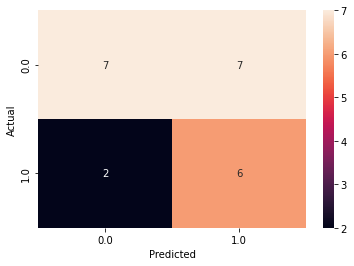

In [71]:
# Plot of the confusion matrix

grid = {'y_test':    y_test,
        'pred': lr_pred
        }

df = pd.DataFrame(grid)
confusion_matrix = pd.crosstab(df['y_test'], df['pred'], rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
plt.show()

In [72]:
# Print of the Classification Report

print(classification_report(y_test, lr_pred))

              precision    recall  f1-score   support

         0.0       0.78      0.50      0.61        14
         1.0       0.46      0.75      0.57         8

    accuracy                           0.59        22
   macro avg       0.62      0.62      0.59        22
weighted avg       0.66      0.59      0.60        22



In [73]:
# Predict the probabilities

pred_proba = lr.predict_proba(X_test)[:,1]

# Get the false_positive_rate, true positive_rate and thresold

false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, pred_proba)

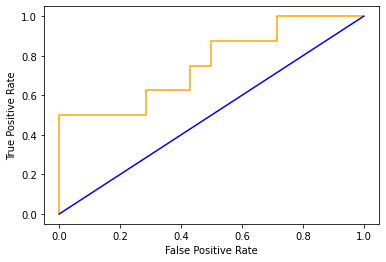

In [74]:
# Plot the ROC curve

plt.plot(false_positive_rate, true_positive_rate, color = 'orange')
plt.plot([0,1], [0,1], color = 'blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [75]:
# Create a function tht converts the predict probabilities to a data frame that compares to the test dataset.
# This will be done in order to evaluate different thresholds in order to see if I can improve the performance with
# different thresholds

def df_converter_test(pred_prob):
    df = pd.DataFrame()
    df['pred_prob'] = pred_prob
    df['test'] = y_test
    return df

# Create a function that converts the predicted probabilities into binary results

def predictor(threshold):
    predictions = []
    for pred_prob in pred_prob_list:
        if pred_prob < threshold:
            predictions.append(0)
        else:
            predictions.append(1)
    return predictions

In [76]:
# See the unique values for the predicted probabilites

np.unique(pred_proba)

array([0.09765894, 0.15776375, 0.17586217, 0.17639564, 0.38601935,
       0.43386432, 0.46590522, 0.48621906, 0.49843339, 0.50708877,
       0.51643029, 0.51823239, 0.52310996, 0.54787426, 0.55241402,
       0.55741881, 0.56341517, 0.6134023 , 0.88378969])

In [77]:
# Apply the defined function to evaluate different thresholds

# Convert the predicted probabilities to a data frame

df = df_converter_test(pred_prob = pred_proba)

# Have the values as a list

pred_prob_list = list(df['pred_prob'])

#Establish the thresholds

thresholds = [0.4, 0.5, 0.6]

In [78]:
# Add the new columns witht the selected threshold

df['threshold_0.5'] = predictor(threshold = 0.5)
df['threshold_0.6'] = predictor(threshold = 0.6)
df['threshold_0.7'] = predictor(threshold = 0.7)

In [79]:
# Accuracy Score of each threshold

print('Accuracy Score with a threshold of 0.5: {}'.format(accuracy_score(y_test, df['threshold_0.5'])))
print('Accuracy Score with a threshold of 0.6: {}'.format(accuracy_score(y_test, df['threshold_0.6'])))
print('Accuracy Score with a threshold of 0.7: {}'.format(accuracy_score(y_test, df['threshold_0.7'])))

Accuracy Score with a threshold of 0.5: 0.5909090909090909
Accuracy Score with a threshold of 0.6: 0.8181818181818182
Accuracy Score with a threshold of 0.7: 0.7727272727272727


### Decision Tree Classifier

In [80]:
# Do the Grid Search Cross Validation 

param_grid = {
             'criterion': ['gini', 'entropy'],
             'max_depth': [3, 5, 7],
             'min_samples_split':[2, 4, 6, 8]
             }

dt = DecisionTreeClassifier()
cv_dt = GridSearchCV(dt, param_grid, cv = 5)
cv_dt_fit = cv_dt.fit(X_train, y_train)

#Print the best parameter
print(cv_dt_fit.best_params_)

{'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 2}


In [81]:
# Make the model with the best hyperparameters

dt = DecisionTreeClassifier(criterion = 'entropy', max_depth = 7, min_samples_split = 4)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)

In [82]:
# Check out train score

print('The model score for the Decision Tree Classifier is {}'.format(dt.score(X_train, y_train)))

The model score for the Decision Tree Classifier is 0.6984126984126984


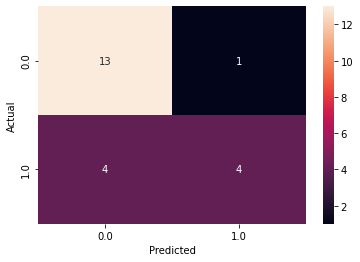

In [83]:
# Plot of the confusion matrix

grid = {'y_test':    y_test,
        'pred': dt_pred
        }

df = pd.DataFrame(grid)
confusion_matrix = pd.crosstab(df['y_test'], df['pred'], rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
plt.show()

In [84]:

# Print of the Classification Report

print(classification_report(y_test, dt_pred))

              precision    recall  f1-score   support

         0.0       0.76      0.93      0.84        14
         1.0       0.80      0.50      0.62         8

    accuracy                           0.77        22
   macro avg       0.78      0.71      0.73        22
weighted avg       0.78      0.77      0.76        22



In [85]:
# Print the accuracy of the model

print('Accuracy of the Decision Tree Classifier model: {}'.format(accuracy_score(y_test, dt_pred)))

Accuracy of the Decision Tree Classifier model: 0.7727272727272727


In [86]:
# Predict the probabilities

pred_proba = dt.predict_proba(X_test)[:,1]

# Get the false_positive_rate, true positive_rate and thresold

false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, pred_proba)

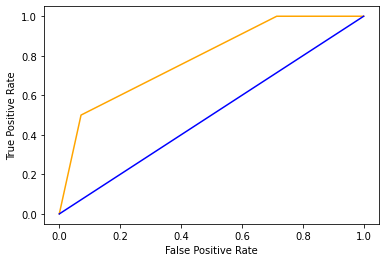

In [87]:
 #Plot the ROC curve

plt.plot(false_positive_rate, true_positive_rate, color = 'orange')
plt.plot([0,1], [0,1], color = 'blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [88]:
# See the unique values for the predicted probabilites

np.unique(pred_proba)

array([0. , 0.5, 1. ])

In [89]:
# Add the new columns witht the selected threshold

df['threshold_0.5'] = predictor(threshold = 0.5)
df['threshold_0.6'] = predictor(threshold = 0.6)
df['threshold_0.7'] = predictor(threshold = 0.7)

In [90]:
# Accuracy Score of each threshold

print('Accuracy Score with a threshold of 0.5: {}'.format(accuracy_score(y_test, df['threshold_0.5'])))
print('Accuracy Score with a threshold of 0.6: {}'.format(accuracy_score(y_test, df['threshold_0.6'])))
print('Accuracy Score with a threshold of 0.7: {}'.format(accuracy_score(y_test, df['threshold_0.7'])))

Accuracy Score with a threshold of 0.5: 0.5909090909090909
Accuracy Score with a threshold of 0.6: 0.8181818181818182
Accuracy Score with a threshold of 0.7: 0.7727272727272727


### Random Forest Classifier

In [91]:
# Do the Grid Search Cross Validation
param_grid = {'n_estimators': [100, 250],
              'criterion' : ['gini', 'entropy'],
              'max_depth': [3, 5, 7],
              }

rf = RandomForestClassifier()
cv_rf = GridSearchCV(rf, param_grid, cv = 5)
cv_rf_fit = cv_rf.fit(X_train, y_train)

#Print the best parameter
print(cv_rf_fit.best_params_)

{'criterion': 'gini', 'max_depth': 5, 'n_estimators': 100}


In [92]:
# Make the model with the best hyperparameters

rf = RandomForestClassifier(criterion = 'gini',max_depth = 5, n_estimators = 100)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

In [93]:
# Check out train score
print('The model score for the Decision Tree Classifier is {}'.format(rf.score(X_train, y_train)))

The model score for the Decision Tree Classifier is 0.8888888888888888


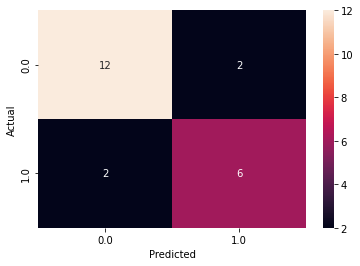

In [94]:

# Plot of the confusion matrix
grid = {'y_test':    y_test,
        'pred': rf_pred
        }

df = pd.DataFrame(grid)
confusion_matrix = pd.crosstab(df['y_test'], df['pred'], rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
plt.show()

In [95]:
# Print of the Classification Report

print(classification_report(y_test,rf_pred))

              precision    recall  f1-score   support

         0.0       0.86      0.86      0.86        14
         1.0       0.75      0.75      0.75         8

    accuracy                           0.82        22
   macro avg       0.80      0.80      0.80        22
weighted avg       0.82      0.82      0.82        22



In [96]:
print('Accuracy of the Random Forest Classifier model: {}'.format(accuracy_score(y_test, rf_pred)))

Accuracy of the Random Forest Classifier model: 0.8181818181818182


In [97]:
# Predict the probabilities

pred_proba = rf.predict_proba(X_test)[:,1]

# Get the false_positive_rate, true positive_rate and thresold

false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, pred_proba)

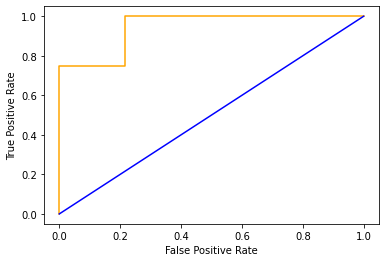

In [98]:
# Plot the ROC curve

plt.plot(false_positive_rate, true_positive_rate, color = 'orange')
plt.plot([0,1], [0,1], color = 'blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [99]:
# Check out the unique values for the probabilities for the Random Forest Classifier

np.unique(pred_proba)

array([0.03080429, 0.12648061, 0.18487864, 0.24794106, 0.32465649,
       0.36386999, 0.37715038, 0.39306084, 0.45980722, 0.47420046,
       0.47484666, 0.48378499, 0.49708112, 0.51271444, 0.53845565,
       0.56604161, 0.61797097, 0.67804272, 0.95321257])

In [100]:
# Apply the defined function to evaluate different thresholds

df = df_converter_test(pred_prob = pred_proba)

pred_prob_list = list(df['pred_prob'])

thresholds = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

In [101]:
# Add the new columns witht the selected threshold

df['threshold_0.3'] = predictor(threshold = 0.3)
df['threshold_0.4'] = predictor(threshold = 0.4)
df['threshold_0.5'] = predictor(threshold = 0.5)
df['threshold_0.6'] = predictor(threshold = 0.6)
df['threshold_0.7'] = predictor(threshold = 0.7)
df['threshold_0.8'] = predictor(threshold = 0.8)

In [102]:
# Accuracy Score of each threshold

print('Accuracy Score with a threshold of 0.3: {}'.format(accuracy_score(y_test, df['threshold_0.3'])))
print('Accuracy Score with a threshold of 0.4: {}'.format(accuracy_score(y_test, df['threshold_0.4'])))
print('Accuracy Score with a threshold of 0.5: {}'.format(accuracy_score(y_test, df['threshold_0.5'])))
print('Accuracy Score with a threshold of 0.6: {}'.format(accuracy_score(y_test, df['threshold_0.6'])))
print('Accuracy Score with a threshold of 0.7: {}'.format(accuracy_score(y_test, df['threshold_0.7'])))
print('Accuracy Score with a threshold of 0.8: {}'.format(accuracy_score(y_test, df['threshold_0.8'])))

Accuracy Score with a threshold of 0.3: 0.5454545454545454
Accuracy Score with a threshold of 0.4: 0.7272727272727273
Accuracy Score with a threshold of 0.5: 0.8181818181818182
Accuracy Score with a threshold of 0.6: 0.8636363636363636
Accuracy Score with a threshold of 0.7: 0.7727272727272727
Accuracy Score with a threshold of 0.8: 0.7727272727272727


### K-Nearest Neighbors

In [103]:
# Create the parameter grid

param_grid = {'n_neighbors': [5, 7, 9],
             'weights': ['uniform', 'distance'],
                }

#Create the model
knn = KNeighborsClassifier()

# Make the Grid Search Cross Validation
cv_knn = GridSearchCV(knn, param_grid, cv = 5)

cv_knn.fit(X_train, y_train)

#Print the best parameter
print(cv_knn.best_params_)

{'n_neighbors': 5, 'weights': 'distance'}


In [104]:
# Create the model with the optimized parameter
kn = KNeighborsClassifier(n_neighbors = 7, algorithm = 'auto', weights = 'distance')
kn.fit(X_train, y_train)
pred_kn = kn.predict(X_test)

In [105]:
# Check out train score
print('The model score for the K-Nearest Neighbor Classifier is {}'.format(kn.score(X_train, y_train)))

The model score for the K-Nearest Neighbor Classifier is 0.8888888888888888


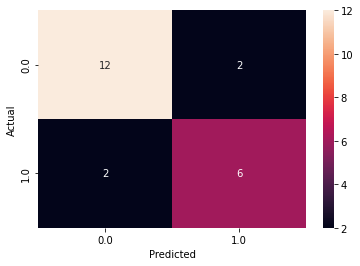

In [106]:
# Plot of the confusion matrix

grid = {'y_test':    y_test,
        'pred': pred_kn
        }

df = pd.DataFrame(grid)
confusion_matrix = pd.crosstab(df['y_test'], df['pred'], rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
plt.show()

In [107]:
# Print the Classification Report

print(classification_report(y_test, pred_kn))

              precision    recall  f1-score   support

         0.0       0.86      0.86      0.86        14
         1.0       0.75      0.75      0.75         8

    accuracy                           0.82        22
   macro avg       0.80      0.80      0.80        22
weighted avg       0.82      0.82      0.82        22



In [108]:
print('Accuracy of the KNeighbors Classifier model: {}'.format(accuracy_score(y_test, pred_kn)))

Accuracy of the KNeighbors Classifier model: 0.8181818181818182


In [109]:
# Predict the probabilities

pred_proba = kn.predict_proba(X_test)[:,1]

# Get the false_positive_rate, true positive_rate and thresold

false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, pred_proba)

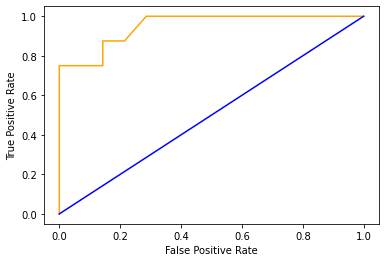

In [110]:

# Plot the ROC curve

plt.plot(false_positive_rate, true_positive_rate, color = 'orange')
plt.plot([0,1], [0,1], color = 'blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [111]:
# See the unique values for the predicted probabilities

np.unique(pred_proba)

array([0.        , 0.12773958, 0.25      , 0.42857143, 0.42857143,
       0.4422423 , 0.5       , 0.67438036, 0.71428571, 1.        ])

In [112]:
# Apply the defined function to evaluate different thresholds

df = df_converter_test(pred_prob = pred_proba)

pred_prob_list = list(df['pred_prob'])

thresholds = [0.5, 0.7, 0.8]

In [113]:
# Add the new columns witht the selected threshold

df['threshold_0.5'] = predictor(threshold = 0.5)
df['threshold_0.6'] = predictor(threshold = 0.6)
df['threshold_0.7'] = predictor(threshold = 0.7)
df['threshold_0.8'] = predictor(threshold = 0.8)

In [114]:
# Accuracy Score of each threshold

print('Accuracy Score with a threshold of 0.5: {}'.format(accuracy_score(y_test, df['threshold_0.5'])))
print('Accuracy Score with a threshold of 0.6: {}'.format(accuracy_score(y_test, df['threshold_0.6'])))
print('Accuracy Score with a threshold of 0.7: {}'.format(accuracy_score(y_test, df['threshold_0.7'])))
print('Accuracy Score with a threshold of 0.8: {}'.format(accuracy_score(y_test, df['threshold_0.8'])))

Accuracy Score with a threshold of 0.5: 0.8636363636363636
Accuracy Score with a threshold of 0.6: 0.8181818181818182
Accuracy Score with a threshold of 0.7: 0.9090909090909091
Accuracy Score with a threshold of 0.8: 0.8636363636363636


### Extra Trees Classifier

In [115]:
# Do the Grid Search Cross Validation

param_grid = {'n_estimators':[100, 250],
              'criterion' : ['gini', 'entropy'],
              'max_depth':[3,5,7]
                }

#Create the model

et = ExtraTreesClassifier()

# Make the Grid Search Cross Validation

cv_et = GridSearchCV(et, param_grid, cv = 5)

cv_et.fit(X_train, y_train)

#Print the best parameter

print(cv_et.best_params_)

{'criterion': 'gini', 'max_depth': 7, 'n_estimators': 250}


In [116]:
# Create the model with the best hyperparameters

et = ExtraTreesClassifier(criterion = 'gini', max_depth = 3, n_estimators = 100)
et.fit(X_train, y_train)
pred_et = et.predict(X_test)

In [117]:
# Check out train score

print('The model score for the Extra Trees Classifier is {}'.format(et.score(X_train, y_train)))

The model score for the Extra Trees Classifier is 0.7777777777777778


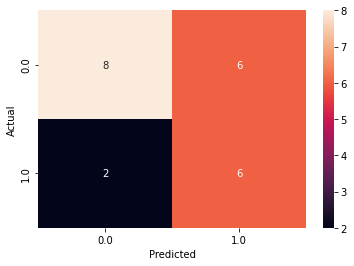

In [118]:
# Plot of the confusion matrix

grid = {'y_test':    y_test,
        'pred': pred_et
        }

df = pd.DataFrame(grid)
confusion_matrix = pd.crosstab(df['y_test'], df['pred'], rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
plt.show()

In [119]:
# Print the Classification Report

print(classification_report(y_test, pred_et))

              precision    recall  f1-score   support

         0.0       0.80      0.57      0.67        14
         1.0       0.50      0.75      0.60         8

    accuracy                           0.64        22
   macro avg       0.65      0.66      0.63        22
weighted avg       0.69      0.64      0.64        22



In [120]:
print('Accuracy of the Extra Trees Classifier model: {}'.format(accuracy_score(y_test, pred_et)))

Accuracy of the Extra Trees Classifier model: 0.6363636363636364


In [121]:
# Predict the probabilities

pred_proba = et.predict_proba(X_test)[:,1]

# Get the false_positive_rate, true positive_rate and thresold

false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, pred_proba)

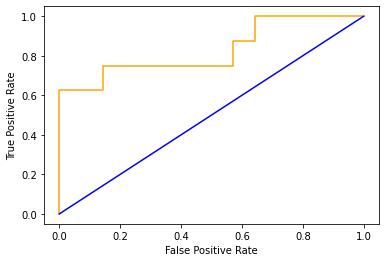

In [122]:
# Plot the ROC curve

plt.plot(false_positive_rate, true_positive_rate, color = 'orange')
plt.plot([0,1], [0,1], color = 'blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [123]:
# See the unique values for the predicted probabilities

np.unique(pred_proba)

array([0.08077634, 0.20494552, 0.2396555 , 0.27741073, 0.46278269,
       0.47015112, 0.47570327, 0.47607389, 0.48604374, 0.48656227,
       0.50556715, 0.5201923 , 0.52688255, 0.53462543, 0.53692471,
       0.5536122 , 0.5648486 , 0.60075498, 0.88685009])

In [124]:
# Apply the defined function to evaluate different thresholds

df = df_converter_test(pred_prob = pred_proba)

pred_prob_list = list(df['pred_prob'])

thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]

In [125]:
# Add the new columns witht the selected threshold

df['threshold_0.3'] = predictor(threshold = 0.3)
df['threshold_0.4'] = predictor(threshold = 0.4)
df['threshold_0.5'] = predictor(threshold = 0.5)
df['threshold_0.6'] = predictor(threshold = 0.6)
df['threshold_0.7'] = predictor(threshold = 0.7)

In [126]:
# Accuracy Score of each threshold

print('Accuracy Score with a threshold of 0.3: {}'.format(accuracy_score(y_test, df['threshold_0.3'])))
print('Accuracy Score with a threshold of 0.4: {}'.format(accuracy_score(y_test, df['threshold_0.4'])))
print('Accuracy Score with a threshold of 0.5: {}'.format(accuracy_score(y_test, df['threshold_0.5'])))
print('Accuracy Score with a threshold of 0.6: {}'.format(accuracy_score(y_test, df['threshold_0.6'])))
print('Accuracy Score with a threshold of 0.7: {}'.format(accuracy_score(y_test, df['threshold_0.7'])))

Accuracy Score with a threshold of 0.3: 0.5454545454545454
Accuracy Score with a threshold of 0.4: 0.5454545454545454
Accuracy Score with a threshold of 0.5: 0.6363636363636364
Accuracy Score with a threshold of 0.6: 0.8181818181818182
Accuracy Score with a threshold of 0.7: 0.7727272727272727


### Voting Classifier

In [127]:
# KNeighbors Classifier

clf1 = KNeighborsClassifier(n_neighbors = 7, algorithm = 'auto', weights = 'distance')

#Logistic Regression

clf2 = LogisticRegression(C = 1.0, penalty = 'l2', tol = 0.01)

# Extra Trees Classifier

clf3 = ExtraTreesClassifier(criterion = 'gini', max_depth = 3, n_estimators = 100)

# Create the Voting Classifier with soft voting because all models performed similarly

clf_voting = VotingClassifier(estimators = [('est1', clf1), ('est2', clf2),
                                           ('est3', clf3)],
                               voting = 'hard')
#Fit and predict

clf_voting.fit(X_train, y_train)
pred_voting = clf_voting.predict(X_test)

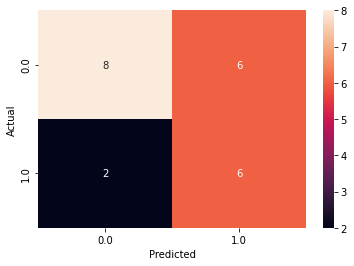

In [128]:
# Plot of the confusion matrix

grid = {'y_test':    y_test,
        'pred': pred_voting
        }

df = pd.DataFrame(grid)
confusion_matrix = pd.crosstab(df['y_test'], df['pred'], rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
plt.show()

In [129]:

# Print the Classification Report

print(classification_report(y_test, pred_voting))

              precision    recall  f1-score   support

         0.0       0.80      0.57      0.67        14
         1.0       0.50      0.75      0.60         8

    accuracy                           0.64        22
   macro avg       0.65      0.66      0.63        22
weighted avg       0.69      0.64      0.64        22



In [130]:
print('Accuracy of the Voting Classifier model: {}'.format(accuracy_score(y_test, pred_voting)))

Accuracy of the Voting Classifier model: 0.6363636363636364


### Weighting to the classifier

In [131]:
# Create empty lists that will storage the different weights

weights1 = []
weights2 = []
weights3 = []
scores = []

# Create a for loop to evaluate different combinations of weights

for i in np.arange(0.1,1, 0.1):
    for j in np.arange(0.1,1, 0.1):
        for k in np.arange(0.1,1, 0.1):
            clf_voting = VotingClassifier(estimators = [('est1', clf1), ('est2', clf2),
                                           ('est3', clf3)], voting = 'soft', weights = [i, j, k])
            clf_voting.fit(X_train, y_train)
            pred = clf_voting.predict(X_test)
            score = accuracy_score(y_test, pred)
            scores.append(score)
            weights1.append(i)
            weights2.append(j)
            weights3.append(k)

In [132]:
# Save the results in a data frame

test_scores = pd.DataFrame()
test_scores['Weight1'] = weights1
test_scores['Weight2'] = weights2
test_scores['Weight3'] = weights3
test_scores['Test Score'] = scores

# Create an additional column to save the sum of all the weights

test_scores['sum_weights'] = test_scores['Weight1'].add(test_scores['Weight2']).add(test_scores['Weight3'])

#We are only getting the rows that the sum of all weights were equal to one

condition = test_scores['sum_weights'] == 1

test_scores = test_scores.loc[condition]

In [133]:
# Sort the values to see the different test scores depending on the weights
test_scores.sort_values(by = 'Test Score', ascending = False).head(15)

,Weight1,Weight2,Weight3,Test Score,sum_weights
567,0.8,0.1,0.1,0.818182,1.0
351,0.5,0.4,0.1,0.818182,1.0
327,0.5,0.1,0.4,0.818182,1.0
335,0.5,0.2,0.3,0.818182,1.0
343,0.5,0.3,0.2,0.818182,1.0
87,0.2,0.1,0.7,0.818182,1.0
407,0.6,0.1,0.3,0.818182,1.0
415,0.6,0.2,0.2,0.818182,1.0
423,0.6,0.3,0.1,0.818182,1.0
487,0.7,0.1,0.2,0.818182,1.0


In [134]:
# Create the Voting Classifier with the most equally weighted because all models performed similarly

clf_voting = VotingClassifier(estimators = [('est1', clf1), ('est2', clf2),
                                           ('est3', clf3)], voting = 'soft', weights = [0.4, 0.3, 0.3])

#Fit and predict

clf_voting.fit(X_train, y_train)
pred_voting = clf_voting.predict(X_test)

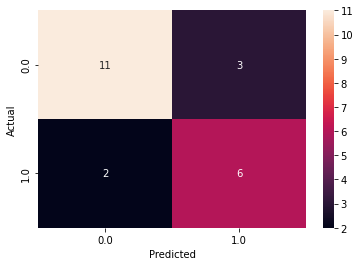

In [135]:
# Plot of the confusion matrix

grid = {'y_test':    y_test,
        'pred': pred_voting
        }

df = pd.DataFrame(grid)
confusion_matrix = pd.crosstab(df['y_test'], df['pred'], rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
plt.show()

In [136]:
# Print the Classification Report

print(classification_report(y_test, pred_voting))

              precision    recall  f1-score   support

         0.0       0.85      0.79      0.81        14
         1.0       0.67      0.75      0.71         8

    accuracy                           0.77        22
   macro avg       0.76      0.77      0.76        22
weighted avg       0.78      0.77      0.78        22



#### Final Conclusion
From all the models we tried, the model that performed the best was the voting classifiers. To make this classifier, I took into consideration the following:

- The classifiers needed to have similar accuracy on the test set.
- The classifiers needed to be if possible, weak classifiers.
- The model with higher accuracy and f1-score was selected as the final model

Because of the reasons, the model selected was the voting classifiers with KNeighbors Classifier, Logistic Regression and Extra Trees Classifier. By using those three classifiers in a voting classifier, I was able to get an accuracy of 0.82, and an f1-score of 0.83 for the unhappy customers and 0.80 for happy customers.

### Feature Importance 

In [137]:
# To see the most important features, we are doing a permutation test with the voting classifier

r = permutation_importance(clf_voting , X_test, y_test, n_repeats = 30, random_state = 0)
                           
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{data3_balanced.columns[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

price_satisfaction_1.21346396784149980.073 +/- 0.032
complete_order_1.00.039 +/- 0.015


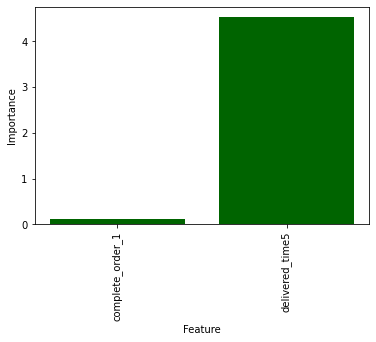

In [138]:
# Plot the feature most important

features = ['complete_order_1', 'delivered_time5']
importance = [0.117, 4.5247746643552]

plt.bar(x = features, height = importance, color = 'darkgreen')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation = 90)
plt.show()

To finalize, the features that mainly impact if a customer is unhappy is if the order was incomplete and what determines if the customer is happy is if the delivered time was good